# Building the Elegant Integration Method

In [1]:
#%matplotlib widget
import numpy as np
import numba
import matplotlib.pyplot as plt
import time
import scipy.optimize
from scipy.spatial.transform import Rotation
from numba.experimental import jitclass
import scipy

In [2]:
@numba.jit
def pulse(t):
	#return np.array([19.1026874e-6*np.cos(6000*t), 0.0, 0.0])
	return np.array([0.0, 0.0, 0.0])

@numba.jit
def grad(pos):
	#return np.zeros(3)
	return np.array([1.0e-6, 0.0, 0.0])

G_CONST = 0 #-9.8
E = np.array([0, 0, 75.0E5], dtype=np.float64)
#E = np.array([0, 0, 0], dtype=precision)
B = np.array([0, 0, 30.0E-7], dtype=np.float64)

## Define a bunch of the coefficients I'll need for the different methods

In [3]:
@numba.jit
def DOP853Coefs():
	COEF = {
		"c2" : 0.526001519587677318785587544488E-01,
		"c3" : 0.789002279381515978178381316732E-01,
		"c4" : 0.118350341907227396726757197510E+00,
		"c5" : 0.281649658092772603273242802490E+00,
		"c6" : 0.333333333333333333333333333333E+00,
		"c7" : 0.25E+00,
		"c8" : 0.307692307692307692307692307692E+00,
		"c9" : 0.651282051282051282051282051282E+00,
		"c10" : 0.6E+00,
		"c11" : 0.857142857142857142857142857142E+00,
		"c14" : 0.1E+00,
		"c15" : 0.2E+00,
		"c16" : 0.777777777777777777777777777778E+00,

		"b1" :   5.42937341165687622380535766363E-2,
		"b6" :   4.45031289275240888144113950566E0,
		"b7" :   1.89151789931450038304281599044E0,
		"b8" :  -5.8012039600105847814672114227E0,
		"b9" :   3.1116436695781989440891606237E-1,
		"b10" : -1.52160949662516078556178806805E-1,
		"b11" :  2.01365400804030348374776537501E-1,
		"b12" :  4.47106157277725905176885569043E-2,

		"bhh1" : 0.244094488188976377952755905512E+00,
		"bhh2" : 0.733846688281611857341361741547E+00,
		"bhh3" : 0.220588235294117647058823529412E-01,

		"er1" :  0.1312004499419488073250102996E-01,
		"er6" : -0.1225156446376204440720569753E+01,
		"er7" : -0.4957589496572501915214079952E+00,
		"er8" :  0.1664377182454986536961530415E+01,
		"er9" : -0.3503288487499736816886487290E+00,
		"er10" :  0.3341791187130174790297318841E+00,
		"er11" :  0.8192320648511571246570742613E-01,
		"er12" : -0.2235530786388629525884427845E-01,

		"a21" :    5.26001519587677318785587544488E-2,
		"a31" :    1.97250569845378994544595329183E-2,
		"a32" :    5.91751709536136983633785987549E-2,
		"a41" :    2.95875854768068491816892993775E-2,
		"a43" :    8.87627564304205475450678981324E-2,
		"a51" :    2.41365134159266685502369798665E-1,
		"a53" :   -8.84549479328286085344864962717E-1,
		"a54" :    9.24834003261792003115737966543E-1,
		"a61" :    3.7037037037037037037037037037E-2,
		"a64" :    1.70828608729473871279604482173E-1,
		"a65" :    1.25467687566822425016691814123E-1,
		"a71" :    3.7109375E-2,
		"a74" :    1.70252211019544039314978060272E-1,
		"a75" :    6.02165389804559606850219397283E-2,
		"a76" :   -1.7578125E-2,

		"a81" :    3.70920001185047927108779319836E-2,
		"a84" :    1.70383925712239993810214054705E-1,
		"a85" :    1.07262030446373284651809199168E-1,
		"a86" :   -1.53194377486244017527936158236E-2,
		"a87" :    8.27378916381402288758473766002E-3,
		"a91" :    6.24110958716075717114429577812E-1,
		"a94" :   -3.36089262944694129406857109825E0,
		"a95" :   -8.68219346841726006818189891453E-1,
		"a96" :    2.75920996994467083049415600797E1,
		"a97" :    2.01540675504778934086186788979E1,
		"a98" :   -4.34898841810699588477366255144E1,
		"a101" :   4.77662536438264365890433908527E-1,
		"a104" :  -2.48811461997166764192642586468E0,
		"a105" :  -5.90290826836842996371446475743E-1,
		"a106" :   2.12300514481811942347288949897E1,
		"a107" :   1.52792336328824235832596922938E1,
		"a108" :  -3.32882109689848629194453265587E1,
		"a109" :  -2.03312017085086261358222928593E-2,

		"a111" :  -9.3714243008598732571704021658E-1,
		"a114" :   5.18637242884406370830023853209E0,
		"a115" :   1.09143734899672957818500254654E0,
		"a116" :  -8.14978701074692612513997267357E0,
		"a117" :  -1.85200656599969598641566180701E1,
		"a118" :   2.27394870993505042818970056734E1,
		"a119" :   2.49360555267965238987089396762E0,
		"a1110" : -3.0467644718982195003823669022E0,
		"a121" :   2.27331014751653820792359768449E0,
		"a124" :  -1.05344954667372501984066689879E1,
		"a125" :  -2.00087205822486249909675718444E0,
		"a126" :  -1.79589318631187989172765950534E1,
		"a127" :   2.79488845294199600508499808837E1,
		"a128" :  -2.85899827713502369474065508674E0,
		"a129" :  -8.87285693353062954433549289258E0,
		"a1210" :  1.23605671757943030647266201528E1,
		"a1211" :  6.43392746015763530355970484046E-1,

		"a141" :  5.61675022830479523392909219681E-2,
		"a147" :  2.53500210216624811088794765333E-1,
		"a148" : -2.46239037470802489917441475441E-1,
		"a149": -1.24191423263816360469010140626E-1,
		"a1410" :  1.5329179827876569731206322685E-1,
		"a1411" :  8.20105229563468988491666602057E-3,
		"a1412" :  7.56789766054569976138603589584E-3,
		"a1413" : -8.298E-3,

		"a151" :  3.18346481635021405060768473261E-2,
		"a156" :  2.83009096723667755288322961402E-2,
		"a157" :  5.35419883074385676223797384372E-2,
		"a158" : -5.49237485713909884646569340306E-2,
		"a1511" : -1.08347328697249322858509316994E-4,
		"a1512" :  3.82571090835658412954920192323E-4,
		"a1513" : -3.40465008687404560802977114492E-4,
		"a1514" :  1.41312443674632500278074618366E-1,
		"a161" : -4.28896301583791923408573538692E-1,
		"a166" : -4.69762141536116384314449447206E0,
		"a167" :  7.68342119606259904184240953878E0,
		"a168" :  4.06898981839711007970213554331E0,
		"a169" :  3.56727187455281109270669543021E-1,
		"a1613" : -1.39902416515901462129418009734E-3,
		"a1614" :  2.9475147891527723389556272149E0,
		"a1615" : -9.15095847217987001081870187138E0,

		"d41" : -0.84289382761090128651353491142E+01,
		"d46" :  0.56671495351937776962531783590E+00,
		"d47" : -0.30689499459498916912797304727E+01,
		"d48" :  0.23846676565120698287728149680E+01,
		"d49" :  0.21170345824450282767155149946E+01,
		"d410" : -0.87139158377797299206789907490E+00,
		"d411" :  0.22404374302607882758541771650E+01,
		"d412" :  0.63157877876946881815570249290E+00,
		"d413" : -0.88990336451333310820698117400E-01,
		"d414" :  0.18148505520854727256656404962E+02,
		"d415" : -0.91946323924783554000451984436E+01,
		"d416" : -0.44360363875948939664310572000E+01,

		"d51" :  0.10427508642579134603413151009E+02,
		"d56" :  0.24228349177525818288430175319E+03,
		"d57" :  0.16520045171727028198505394887E+03,
		"d58" : -0.37454675472269020279518312152E+03,
		"d59" : -0.22113666853125306036270938578E+02,
		"d510" :  0.77334326684722638389603898808E+01,
		"d511" : -0.30674084731089398182061213626E+02,
		"d512" : -0.93321305264302278729567221706E+01,
		"d513" :  0.15697238121770843886131091075E+02,
		"d514" : -0.31139403219565177677282850411E+02,
		"d515" : -0.93529243588444783865713862664E+01,
		"d516" :  0.35816841486394083752465898540E+02,

		"d61" :  0.19985053242002433820987653617E+02,
		"d66" : -0.38703730874935176555105901742E+03,
		"d67" : -0.18917813819516756882830838328E+03,
		"d68" :  0.52780815920542364900561016686E+03,
		"d69" : -0.11573902539959630126141871134E+02,
		"d610" :  0.68812326946963000169666922661E+01,
		"d611" : -0.10006050966910838403183860980E+01,
		"d612" :  0.77771377980534432092869265740E+00,
		"d613" : -0.27782057523535084065932004339E+01,
		"d614" : -0.60196695231264120758267380846E+02,
		"d615" :  0.84320405506677161018159903784E+02,
		"d616" :  0.11992291136182789328035130030E+02,

		"d71" : -0.25693933462703749003312586129E+02,
		"d76" : -0.15418974869023643374053993627E+03,
		"d77" : -0.23152937917604549567536039109E+03,
		"d78":  0.35763911791061412378285349910E+03,
		"d79":  0.93405324183624310003907691704E+02,
		"d710" : -0.37458323136451633156875139351E+02,
		"d711" :  0.10409964950896230045147246184E+03,
		"d712" :  0.29840293426660503123344363579E+02,
		"d713" : -0.43533456590011143754432175058E+02,
		"d714" :  0.96324553959188282948394950600E+02,
		"d715" : -0.39177261675615439165231486172E+02,
		"d716" : -0.14972683625798562581422125276E+03
	}
	return COEF

@numba.jit
def rkParamDef():
	rk45COEF = {
		'A1': 0.0,
		'A2': 2.0/9.0,
		'A3': 1.0/3.0,
		'A4': 3.0/4.0,
		'A5': 1.0,
		'A6': 5.0/6.0,
		'B21': 2.0/9.0,
		'B31': 1.0/12.0,
		'B32': 1.0/4.0,
		'B41': 69/128,
		'B42': -243/128,
		'B43': 135/64,
		'B51': -17/12,
		'B52': 27/4,
		'B53': -27/5,
		'B54': 16/15,
		'B61': 65/432,
		'B62': -5/16,
		'B63': 13/16,
		'B64': 4/27,
		'B65': 5/144,
		'C1': 1/9,
		'C2': 0,
		'C3': 9/20,
		'C4': 16/45,
		'C5': 1/12,
		'CH1': 47/450,
		'CH2': 0,
		'CH3': 12/25,
		'CH4': 32/225,
		'CH5': 1/30,
		'CH6': 6/25,
		'CT1': 1/150,
		'CT2': 0,
		'CT3': -3/100,
		'CT4': 16/75,
		'CT5': 1/20,
		'CT6':-6/25,
	}
	return rk45COEF

@numba.jit
def RK75109Coefs():
	coef = {
		'A1': 0.0,
		'A2': 4/63,
		'A3': 2/21,
		'A4': 1/7,
		'A5': 7/17,
		'A6': 13/24,
		'A7': 7/9,
		'A8': 91/100,
		'A9': 1,
		'B21': 4/63,
		'B31': 1/42,
		'B32': 1/14,
		'B41': 1/28,
		'B42': 0,
		'B43': 3/28,
		'B51': 12551/19652,
		'B52': 0,
		'B53': -48363/19652,
		'B54': 10976/4913,
		'B61': -36616931/27869184,
		'B62': 0,
		'B63': 2370277/442368,
		'B64': -255519173/63700992,
		'B65': 226798819/445906944,
		'B71': -10401401/7164612,
		'B72': 0,
		'B73': 47383/8748,
		'B74': -4914455/1318761,
		'B75': -1498465/7302393,
		'B76': 2785280/3739203,
		'B81': 181002080831/17500000000,
		'B82': 0,
		'B83': -14827049601/400000000,
		'B84': 23296401527134463/857600000000000,
		'B85': 2937811552328081/949760000000000,
		'B86': -243874470411/69355468750,
		'B87': 2857867601589/3200000000000,
		'B91': -228380759/19257212,
		'B92': 0,
		'B93': 4828803/113948,
		'B94': -331062132205/10932626912,
		'B95': -12727101935/3720174304,
		'B96': 22627205314560/4940625496417,
		'B97': -268403949/461033608,
		'B98': 3600000000000/19176750553961,
		'C1': 95/2366,
		'C2': 0,
		'C3': 0,
		'C4': 3822231133/16579123200,
		'C5': 555164087/2298419200,
		'C6': 1279328256/9538891505,
		'C7': 5963949/25894400,
		'C8': 50000000000/599799373173,
		'C9': 28487/712800,
		'CH1': 1689248233/50104356120,
		'CH2': 0,
		'CH3': 0,
		'CH4': 1/4,
		'CH5': 28320758959727/152103780259200,
		'CH6': 66180849792/341834007515,
		'CH7': 31163653341/152322513280,
		'CH8': 36241511875000/394222326561063,
		'CH9': 28487/712800
	}
	return coef

## First coming up with the decomposition methodology

In [4]:
@numba.jit
def calcGamma(v):
	return 1.0/np.sqrt(1-(v/299792458.0)**2.0)

@numba.jit
def vecLen(a):
	return np.sqrt(np.sum(np.square(a)))

@numba.jit
def vecNorm(a):
	return a/vecLen(a)

@numba.jit
def BMT(t, s, x, v, a, B0, E0, consts):
	if vecLen(v) < 10.0: #the non-relativistic case
		BPrime = B0 -1.0/89875517873681764.0*np.cross(v, E0)
		wt = 1.0/(89875517873681764.0*2.0)*np.cross(a, v)
		crossVal = -2.0*consts['mu']/(consts['hbar'])*BPrime + wt
		s = np.cross(crossVal, s)
	else:#allow for relativity even though it's probably not going to do anything at this scale
		gamma = calcGamma(vecLen(v))
		BPrime = gamma*B0+(1-gamma)*(np.dot(B0, v))*v/vecLen(v)**2.0 - gamma/89875517873681764.0*np.cross(v, E0)
		wt = gamma**2.0 / (89875517873681764.0*(gamma+1))*np.cross(a, v)
		#update the spin
		crossVal = -2.0*consts['mu']/(gamma*consts['hbar'])*BPrime + wt
		s = np.cross(crossVal, s)
	return s

@numba.jit
def BMTCross(s, x, v, a, B0, E0, consts):
	crossVal = 0
	if vecLen(v) < 10.0: #the non-relativistic case
		BPrime = B0 -1.0/89875517873681764.0*np.cross(v, E0)
		wt = 1.0/(89875517873681764.0*2.0)*np.cross(a, v)
		crossVal = -2.0*consts['mu']/(consts['hbar'])*BPrime + wt
	else:#allow for relativity even though it's probably not going to do anything at this scale
		gamma = calcGamma(vecLen(v))
		BPrime = gamma*B0+(1-gamma)*(np.dot(B0, v))*v/vecLen(v)**2.0 - gamma/89875517873681764.0*np.cross(v, E0)
		wt = gamma**2.0 / (89875517873681764.0*(gamma+1))*np.cross(a, v)
		#update the spin
		crossVal = -2.0*consts['mu']/(gamma*consts['hbar'])*BPrime + wt
	return crossVal

@numba.jit
def determineMatrix(s):
	return np.array([[0, s[2], -s[1]], 
					 [-s[2], 0, s[0]], 
					 [s[1], -s[0], 0]])

@numba.jit
def determineQuaternion(a, b):
	return np.array([a, b[0], b[1], b[2]])

@numba.jit
def rodriguez(k, dt):
	angle = vecLen(k)
	norm = k[:]/angle
	K = determineMatrix(norm) #calculate the matrix from this vector
	h = angle*dt
	return np.identity(3)+np.sin(h)*K+(1-np.cos(h))*np.dot(K, K)

@numba.jit
def rodriguezQuat(k, dt):
	angle = vecLen(k)
	norm = k/angle
	h = angle * dt
	return determineQuaternion(np.cos(h/2.0), -np.sin(h/2.0)*norm)

@numba.jit
def oneStepForward(dt, s, x, v, a, B, E, consts):
	crossVal = BMTCross(s, x, v, a, B, E, consts)
	rotation = rodriguez(crossVal, dt)
	return np.dot(rotation, s)

@numba.jit
def normalMethod(dt, s, x, v, a, B, E, consts):
	crossVal = BMTCross(s, x, v, a, B, E, consts)
	return np.cross(crossVal, s)

@numba.jit
def qConjugate(q):
	w, x, y, z = q
	return np.array([w, -x, -y, -z], dtype=q.dtype)

@numba.jit
def qMult(q1, q2):
	w1, x1, y1, z1 = q1
	w2, x2, y2, z2 = q2
	w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
	x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
	y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
	z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
	return np.array([w, x, y, z], dtype=q1.dtype)

@numba.jit
def qv_mult(q1, v1):
	q2 = np.array([0.0, *v1], dtype=q1.dtype)
	return qMult(qMult(q1, q2), qConjugate(q1))[1:]

@numba.jit
def timingRotMeth(init, k, dt):
	normal = rodriguez(k[:], dt)
	return np.dot(normal, init)

@numba.jit
def timingQuatMeth(init, k, dt):
	normal = rodriguezQuat(k[:], dt)
	return qv_mult(normal, init)

In [5]:
test = DOP853Coefs()
print(test['bhh1'] + test['bhh2']+ test['bhh3'])
print(test['er1'] + test['er6'] + test['er7'] + test['er8'] + test['er9'] + test['er10'] + test['er11'] + test['er12'])

1.0
-1.5959455978986625e-16


## DOP853 Based Methods

### Standard DOP853 Routine

In [6]:
@numba.jit
def obs_dense(xold, x, y, pos_old, v_old, opts, 
			  lastOutput, lastIndex, outputArray, hout, rcont1, rcont2, 
			  rcont3, rcont4, rcont5, rcont6, rcont7, rcont8):
	s = None
	s1 = None
	dense_out = None
	while lastOutput < x:
		s = (lastOutput - xold)/hout
		s1 = 1.0 - s
		dense_out = rcont1+s*(rcont2+s1*(rcont3+s*(rcont4+s1*(rcont5+s*(rcont6+s1*(rcont7+s*rcont8))))))
		a = np.array([0.0, G_CONST, 0.0])
		outPos = pos_old + v_old * (x-xold) + 0.5*a*(x-xold)*(x-xold)
		temp = (lastOutput, outPos[0], outPos[1], outPos[2], dense_out[0], dense_out[1], dense_out[2])
		outputArray[lastIndex,:] = temp
		#print(lastIndex, lastOutput, x, opts['ioutInt'])
		lastIndex += 1
		lastOutput += np.float64(opts['ioutInt'])
	return lastIndex, lastOutput

@numba.jit
def sign(a, b):
	if b < 0.0:
		return -abs(a)
	return abs(a)

@numba.jit
def max_d3(a, b):
	out = []
	for i in range(len(a)):
		out.append(max(a[i], b[i]))
	return np.array(out)

@numba.jit
def interpolate(t, t0, tf, p_old, p_new, v_old, v_new):
	p_out = (p_old*(tf-t) + p_new*(t-t0))/(tf-t0)
	v_out = v_old
	return p_out, v_out

@numba.jit
def Bloch(t, y, B0, gamma, t0, tf , p_old, p_new, v_old, v_new):
	p, v = interpolate(t,t0,tf,p_old,p_new,v_old,v_new);
	Bx = pulse(t);
	G = grad(p);
	B = Bx + G + B0
	return gamma * np.cross(y, B);

@numba.jit
def DOP853(t0, tf, y, p_old, p_new, v_old, v_new, 
			  OPT, lastOutput, lastIndex, outputArray, precision = np.float64):
	COEF = DOP853Coefs()
	yy1 = np.array([0, 0,  0], dtype=precision)
	k1 = np.array([0, 0,  0], dtype=precision)
	k2 = np.array([0, 0,  0], dtype=precision)
	k3 = np.array([0, 0,  0], dtype=precision)
	k4 = np.array([0, 0,  0], dtype=precision)
	k5 = np.array([0, 0,  0], dtype=precision)
	k6 = np.array([0, 0,  0], dtype=precision)
	k7 = np.array([0, 0,  0], dtype=precision)
	k8 = np.array([0, 0,  0], dtype=precision)
	k9 = np.array([0, 0,  0], dtype=precision)
	k10 = np.array([0, 0,  0], dtype=precision)
	rcont1 = np.array([0, 0,  0], dtype=precision)
	rcont2 = np.array([0, 0,  0], dtype=precision)
	rcont3 = np.array([0, 0,  0], dtype=precision)
	rcont4 = np.array([0, 0,  0], dtype=precision)
	rcont5 = np.array([0, 0,  0], dtype=precision)
	rcont6 = np.array([0, 0,  0], dtype=precision)
	rcont7 = np.array([0, 0,  0], dtype=precision)
	rcont8 = np.array([0, 0,  0], dtype=precision)
	idid = 0
	iasti = 0
	iord = 0
	reject = 0
	last = 0
	nonsti = 0
	facold = 1.0E-4
	expo1 = 1.0/8.0 - np.float64(OPT['beta']) * 0.2;
	fac = 0.0
	facc1 = 1.0 / np.float64(OPT['fac1']);
	facc2 = 1.0 / np.float64(OPT['fac2']);
	fac11 = 0.0
	posneg = sign(1.0, tf-t0);
	xph = 0.0
	stnum  = 0.0
	stden = 0.0
	err2 = 0.0
	deno = 0.0
	erri = np.array([0, 0,  0], dtype=precision)
	sqr = np.array([0, 0,  0], dtype=precision)
	sk = np.array([0, 0,  0], dtype=precision)
	atoli = np.float64(OPT['atol'])
	rtoli = np.float64(OPT['rtol'])
	hlamb = 0.0
	err = 0.0
	hnew = 0.0
	ydiff = np.array([0, 0,  0], dtype=precision)
	bspl = np.array([0, 0,  0], dtype=precision)
	nfcn = 0
	nstep = 0
	naccpt = 0 
	nrejct = 0
	hout = 0.0 
	xold = 0.0
	xout = 0.0
	x = t0
	xf = tf
	h = np.float64(OPT['h'])
	i = 0
	n = 3
	last  = 0
	hlamb = 0.0
	iasti = 0
	B0 = np.array([OPT['B0x'], OPT['B0y'], OPT['B0z']])
	k1 = Bloch(x, y, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new);

	hmax = np.abs(np.float64(OPT['hmax']))
	iord = 8
	nfcn += 2
	reject = 0
	xold = x
	while 1:
		if nstep > np.float64(OPT['nmax']):
			xout = x
			hout = h
			return nstep
		if 0.1 * abs(h) <= abs(x) * np.float64(OPT['uround']):
			xout = x
			hout = h;
			return nstep
		if (x + 1.01*h - xf) * posneg > 0.0 :
			h = xf - x
			last = 1
		nstep+=1
		yy1 = y + h * COEF['a21'] * k1;
		k2 = Bloch(x+COEF['c2']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new);

		yy1 = y + h * (COEF['a31']*k1 + COEF['a32']*k2);
		k3 = Bloch(x+COEF['c3']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new);

		yy1 = y + h * (COEF['a41']*k1 + COEF['a43']*k3);
		k4 = Bloch(x+COEF['c4']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new);

		yy1 = y + h * (COEF['a51']*k1 + COEF['a53']*k3 + COEF['a54']*k4);
		k5 = Bloch(x+COEF['c5']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new);

		yy1 = y + h * (COEF['a61']*k1 + COEF['a64']*k4 + COEF['a65']*k5);
		k6 = Bloch(x+COEF['c6']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new);

		yy1 = y + h * (COEF['a71']*k1 + COEF['a74']*k4 + COEF['a75']*k5 + COEF['a76']*k6);
		k7 = Bloch(x+COEF['c7']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new);

		yy1 = y + h * (COEF['a81']*k1 + COEF['a84']*k4 + COEF['a85']*k5 + COEF['a86']*k6 + COEF['a87']*k7);
		k8 = Bloch(x+COEF['c8']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new);

		yy1 = y + h * (COEF['a91']*k1 + COEF['a94']*k4 + COEF['a95']*k5 + COEF['a96']*k6 + COEF['a97']*k7 + COEF['a98']*k8);
		k9 = Bloch(x+COEF['c9']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new);

		yy1 = y + h * (COEF['a101']*k1 + COEF['a104']*k4 + COEF['a105']*k5 + COEF['a106']*k6 + COEF['a107']*k7 + COEF['a108']*k8 + COEF['a109']*k9);
		k10 = Bloch(x+COEF['c10']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new);

		yy1 = y + h * (COEF['a111']*k1 + COEF['a114']*k4 + COEF['a115']*k5 + COEF['a116']*k6 + COEF['a117']*k7 + COEF['a118']*k8 + COEF['a119']*k9 + COEF['a1110']*k10);

		k2 = Bloch(x+COEF['c11']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new);
		xph = x + h;

		yy1 = y + h * (COEF['a121']*k1 + COEF['a124']*k4 + COEF['a125']*k5 + COEF['a126']*k6 + COEF['a127']*k7 + COEF['a128']*k8 + COEF['a129']*k9 + COEF['a1210']*k10 + COEF['a1211']*k2);

		k3 = Bloch(xph, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new);
		nfcn += 11;

		k4 = COEF['b1']*k1 + COEF['b6']*k6 + COEF['b7']*k7 + COEF['b8']*k8 + COEF['b9']*k9 + COEF['b10']*k10 + COEF['b11']*k2 + COEF['b12']*k3;
		k5 = y + h * k4;

		# error estimation 
		err = 0.0;
		err2 = 0.0;
		sk = atoli + rtoli * max_d3(np.abs(y), np.abs(k5));
		erri = k4 - np.float64(COEF['bhh1'])*k1 - np.float64(COEF['bhh2'])*k9 - np.float64(COEF['bhh3'])*k3;
		sqr = erri / sk;
		err2 += sum(sqr*sqr);
		erri = np.float64(COEF['er1'])*k1 + np.float64(COEF['er6'])*k6 + np.float64(COEF['er7'])*k7 + np.float64(COEF['er8'])*k8 +\
			np.float64(COEF['er9'])*k9 + np.float64(COEF['er10'])*k10 + np.float64(COEF['er11'])*k2 + np.float64(COEF['er12'])*k3;
		sqr = erri / sk;
		err += sum(sqr*sqr);

		deno = err + 0.01 * err2;
		if deno <= 0.0:
			deno = 1.0;
		err = abs(h) * err * np.sqrt (1.0 / (deno*n));

		# computation of hnew 
		fac11 = pow (err, expo1);
		# Lund-stabilization 
		fac = fac11 / pow(facold,np.float64(OPT['beta']));
		# we require fac1 <= hnew/h <= fac2 
		fac = max (facc2, min (facc1, fac/np.float64(OPT['safe'])));
		hnew = h / fac;
		#print(x, h, hnew)
		if err <= 1.0:
			# step accepted 
			facold = max (err, 1.0E-4);
			naccpt+=1;
			k4 = Bloch(xph, k5, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new);
			nfcn+=1;
			# final preparation for dense output 
			if OPT['iout'] == 2:
				# save the first function evaluations 
				rcont1 = y;
				ydiff = k5 - y;
				rcont2 = ydiff;
				bspl = h * k1 - ydiff;
				rcont3 = bspl;
				rcont4 = ydiff - h*k4 - bspl;
				rcont5 = COEF['d41']*k1 + COEF['d46']*k6 + COEF['d47']*k7 + COEF['d48']*k8 + COEF['d49']*k9 + COEF['d410']*k10 + COEF['d411']*k2 + COEF['d412']*k3;
				rcont6 = COEF['d51']*k1 + COEF['d56']*k6 + COEF['d57']*k7 + COEF['d58']*k8 + COEF['d59']*k9 + COEF['d510']*k10 + COEF['d511']*k2 + COEF['d512']*k3;
				rcont7 = COEF['d61']*k1 + COEF['d66']*k6 + COEF['d67']*k7 + COEF['d68']*k8 + COEF['d69']*k9 + COEF['d610']*k10 + COEF['d611']*k2 + COEF['d612']*k3;
				rcont8 = COEF['d71']*k1 + COEF['d76']*k6 + COEF['d77']*k7 + COEF['d78']*k8 + COEF['d79']*k9 + COEF['d710']*k10 + COEF['d711']*k2 + COEF['d712']*k3;
				# the next three function evaluations
				yy1 = y + h * (COEF['a141']*k1 + COEF['a147']*k7 + COEF['a148']*k8 + COEF['a149']*k9 + COEF['a1410']*k10 + COEF['a1411']*k2 + COEF['a1412']*k3 + COEF['a1413']*k4);
				k10 = Bloch(x+COEF['c14']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new);
				yy1 = y + h * (COEF['a151']*k1 + COEF['a156']*k6 + COEF['a157']*k7 + COEF['a158']*k8 + COEF['a1511']*k2 + COEF['a1512']*k3 + COEF['a1513']*k4 + COEF['a1514']*k10);
				k2 = Bloch(x+COEF['c15']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new);
				yy1 = y + h * (COEF['a161']*k1 + COEF['a166']*k6 + COEF['a167']*k7 + COEF['a168']*k8 + COEF['a169']*k9 + COEF['a1613']*k4 + COEF['a1614']*k10 + COEF['a1615']*k2);
				k3 = Bloch(x+COEF['c16']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new);
				nfcn += 3;
				# final preparation #
				rcont5 = h * (rcont5 + COEF['d413']*k4 + COEF['d414']*k10 + COEF['d415']*k2 + COEF['d416']*k3);
				rcont6 = h * (rcont6 + COEF['d513']*k4 + COEF['d514']*k10 + COEF['d515']*k2 + COEF['d516']*k3);
				rcont7 = h * (rcont7 + COEF['d613']*k4 + COEF['d614']*k10 + COEF['d615']*k2 + COEF['d616']*k3);
				rcont8 = h * (rcont8 + COEF['d713']*k4 + COEF['d714']*k10 + COEF['d715']*k2 + COEF['d716']*k3);
			k1 = k4;
			y = k5;
			xold = x;
			x = xph;
			if OPT['iout'] == 2:
				hout = h;
				xout = x;
				lastIndex, lastOutput = obs_dense(xold, x, y, p_old, v_old, OPT, lastOutput, lastIndex, outputArray, hout, rcont1, rcont2, rcont3, rcont4, rcont5, rcont6, rcont7, rcont8);
			# normal exit 
			if last:
				hout=hnew;
				xout = x;
				return nstep
			if abs(hnew) > hmax:
				hnew = posneg * hmax;
			if reject:
				hnew = posneg * min (abs(hnew), abs(h));
			reject = 0;
		else:
			# step rejected
			hnew = h / min (facc1, fac11/np.float64(OPT['safe']));
			reject = 1;
			if naccpt >= 1:
				nrejct=nrejct + 1;
			last = 0;
		h = hnew;
	return nstep

### DOP853 With Rotation Matrices Version

In [7]:
@numba.jit
def interpolate(t, t0, tf, p_old, p_new, v_old, v_new):
	p_out = (p_old*(tf-t) + p_new*(t-t0))/(tf-t0)
	v_out = v_old
	return p_out, v_out

@numba.jit
def findCrossTerm(t, y, B0, gamma, t0, tf , p_old, p_new, v_old, v_new):
	p, v = interpolate(t,t0,tf,p_old,p_new,v_old,v_new);
	Bx = pulse(t);
	G = grad(p);
	B = Bx + G + B0
	crossVal = gamma * B
	return crossVal

@numba.jit
def appCross(y, cross, dt):
	rotation = rodriguez(cross, dt)
	#print(rotation)
	return np.dot(rotation, y)

@numba.jit
def BlochNew(t, dt, y, B0, gamma, t0, tf , p_old, p_new, v_old, v_new):
	crossVal = findCrossTerm(t, y, B0, gamma, t0, tf , p_old, p_new, v_old, v_new)
	rotation = rodriguez(crossVal, dt)
	#print(rotation)
	trueS = np.dot(rotation, y)
	return trueS

@numba.jit
def Bloch(t, y, B0, gamma, t0, tf , p_old, p_new, v_old, v_new):
	p, v = interpolate(t,t0,tf,p_old,p_new,v_old,v_new);
	Bx = pulse(t);
	G = grad(p);
	B = Bx + G + B0
	return gamma * np.cross(y, B);

@numba.jit
def DOP853Rotation(t0, tf, y, p_old, p_new, v_old, v_new, 
			  OPT, lastOutput, lastIndex, outputArray, precision = np.float64):
	B0 = np.array([OPT['B0x'], OPT['B0y'], OPT['B0z']])
	COEF = DOP853Coefs()
	idid = 0
	iasti = 0
	iord = 0
	reject = 0
	last = 0
	nonsti = 0
	facold = 1.0E-4
	expo1 = 1.0/8.0 - np.float64(OPT['beta']) * 0.2;
	fac = 0.0
	facc1 = 1.0 / np.float64(OPT['fac1']);
	facc2 = 1.0 / np.float64(OPT['fac2']);
	fac11 = 0.0
	posneg = sign(1.0, tf-t0);
	xph = 0.0
	stnum  = 0.0
	stden = 0.0
	err2 = 0.0
	deno = 0.0
	erri = np.array([0, 0,  0], dtype=precision)
	sqr = np.array([0, 0,  0], dtype=precision)
	sk = np.array([0, 0,  0], dtype=precision)
	atoli = np.float64(OPT['atol'])
	rtoli = np.float64(OPT['rtol'])
	hlamb = 0.0
	err = 0.0
	hnew = 0.0
	ydiff = np.array([0, 0,  0], dtype=precision)
	bspl = np.array([0, 0,  0], dtype=precision)
	nfcn = 0
	nstep = 0
	naccpt = 0 
	nrejct = 0
	hout = 0.0 
	xold = 0.0
	xout = 0.0
	x = t0
	xf = tf
	h = np.float64(OPT['h'])
	i = 0
	n = 3
	last  = 0
	hlamb = 0.0
	iasti = 0

	hmax = np.abs(np.float64(OPT['hmax']))
	iord = 8
	nfcn += 2
	reject = 0
	xold = x
	while 1:
		nstep+=1
		endOfSimulDt = tf - x #how long until the end of the simulation
		nextOutputDt = lastOutput + np.float64(OPT['ioutInt']) - x #how long to the next output time
		if endOfSimulDt <= nextOutputDt and endOfSimulDt <= h:
			stop = True
			h = endOfSimulDt
		elif nextOutputDt <= endOfSimulDt and nextOutputDt <= h:
			stop = False
			out = True
			h = nextOutputDt
		elif h <= nextOutputDt and h <= endOfSimulDt:
			stop = False
			out = False
			h = h
		
		k1q = findCrossTerm(x, y, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		k2q = findCrossTerm(x+COEF['c2']*h, appCross(
			y, k1q, COEF['a21']*h), B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		k3q = findCrossTerm(x+COEF['c3']*h, appCross(appCross(
			y, k1q, COEF['a31']*h), k2q, COEF['a32']*h), B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		
		k4q = findCrossTerm(x+COEF['c4']*h, appCross(appCross(
			y, k1q, COEF['a41']*h), k3q, COEF['a43']*h), B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		
		k5q = findCrossTerm(x+COEF['c5']*h, appCross(appCross(appCross(
			y, k1q, COEF['a51']*h), k3q, COEF['a53']*h), k4q, COEF['a54']*h), B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		
		k6q = findCrossTerm(x+COEF['c6']*h, appCross(appCross(appCross(
			y, k1q, COEF['a61']*h), k4q, COEF['a64']*h), k5q, COEF['a65']*h), B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		
		k7q = findCrossTerm(x+COEF['c7']*h, appCross(appCross(appCross(appCross(
			y, k1q, COEF['a71']*h), k4q, COEF['a74']*h), k5q, COEF['a75']*h), k6q, COEF['a76']*h), B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		#print(appCross(appCross(appCross(appCross(appCross(
		#	y, k1q, COEF['a81']*h), k4q, COEF['a84']*h), k5q, COEF['a85']*h), k6q, COEF['a86']*h), k7q, COEF['a87']*h))
		k8q = findCrossTerm(x+COEF['c8']*h, appCross(appCross(appCross(appCross(appCross(
			y, k1q, COEF['a81']*h), k4q, COEF['a84']*h), k5q, COEF['a85']*h), k6q, COEF['a86']*h), k7q, COEF['a87']*h), B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		#print(appCross(appCross(appCross(appCross(appCross(appCross(
		#	y, k1q, COEF['a91']*h), k4q, COEF['a94']*h), k5q, COEF['a95']*h), k6q, COEF['a96']*h), k7q, COEF['a97']*h), k8q, COEF['a98']*h))
		k9q = findCrossTerm(x+COEF['c9']*h, appCross(appCross(appCross(appCross(appCross(appCross(
			y, k1q, COEF['a91']*h), k4q, COEF['a94']*h), k5q, COEF['a95']*h), k6q, COEF['a96']*h), k7q, COEF['a97']*h), k8q, COEF['a98']*h), B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		#print(appCross(appCross(appCross(appCross(appCross(appCross(appCross(
		#	y, k1q, COEF['a101']*h), k4q, COEF['a104']*h), k5q, COEF['a105']*h), k6q, COEF['a106']*h), k7q, COEF['a107']*h), k8q, COEF['a108']*h), k9q, COEF['a109']*h))
		k10q = findCrossTerm(x+COEF['c10']*h, appCross(appCross(appCross(appCross(appCross(appCross(appCross(
			y, k1q, COEF['a101']*h), k4q, COEF['a104']*h), k5q, COEF['a105']*h), k6q, COEF['a106']*h), k7q, COEF['a107']*h), k8q, COEF['a108']*h), k9q, COEF['a109']*h), B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		
		yy1q = appCross(appCross(appCross(appCross(appCross(appCross(appCross(appCross(
			y, k1q, COEF['a111']*h), k4q, COEF['a114']*h), k5q, COEF['a115']*h), k6q, COEF['a116']*h), k7q, COEF['a117']*h), k8q, COEF['a118']*h), k9q, COEF['a119']*h), k10q, COEF['a1110']*h)
		
		k2q = findCrossTerm(x+COEF['c11']*h, yy1q, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new);
		xph = x + h;

		yy1q = appCross(appCross(appCross(appCross(appCross(appCross(appCross(appCross(appCross(
            y, k1q, h*COEF['a121']), k4q, h*COEF['a124']), k5q, h*COEF['a125']), k6q, h*COEF['a126']), k7q, h*COEF['a127']), k8q, h*COEF['a128']), k9q, h*COEF['a129']), k10q, h*COEF['a1210']), k2q, h*COEF['a1211'])
		#print(yy1q)
		k3q = findCrossTerm(xph, yy1q, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new);
		nfcn += 11;

		k4q = rodriguez(k3q, h*COEF['b12'])@(rodriguez(k2q, h*COEF['b11'])@(rodriguez(k10q, h*COEF['b10'])@(
			rodriguez(k9q, h*COEF['b9'])@(rodriguez(k8q, h*COEF['b8'])@(rodriguez(k7q, h*COEF['b7'])@(rodriguez(k6q, h*COEF['b6'])@rodriguez(k1q, h*COEF['b1'])))))))
		k5q = k4q@y #k4 is the rotation matrix
		# error estimation 
		err = 0.0;
		err2 = 0.0;
		sk = atoli + rtoli * max_d3(np.abs(y), np.abs(k5q));
		#erri = k4 - COEF['bhh1']*k1 - COEF['bhh2']*k9 - COEF['bhh3']*k3
		#This one is a different method of finding the endpoint based on previously calculated values
		erri = k4q@y - appCross(appCross(appCross(y, k1q, COEF['bhh1']*h), k9q, COEF['bhh2']*h), k3q, COEF['bhh3']*h)
		#erri = k4@y - (rodriguez(k1, COEF['bhh1']*h)@(rodriguez(k9, COEF['bhh2']*h)@(rodriguez(k3, COEF['bhh3']*h))))@y;
		#print(erri)
		erri = np.max(np.square(erri))
		sqr = erri / sk;
		err2 += sum(sqr*sqr);
		#erri = COEF['er1']*k1 + COEF['er6']*k6 + COEF['er7']*k7 + COEF['er8']*k8 + COEF['er9']*k9 + COEF['er10']*k10 + COEF['er11']*k2 + COEF['er12']*k3;
		#erri = (np.identity(3) - rodriguez(k1q, COEF['er1']*h)@(rodriguez(k6q, COEF['er6']*h)@(rodriguez(k7q, COEF['er7']*h)@(\
		#	rodriguez(k8q, COEF['er8']*h)@(rodriguez(k9q, COEF['er9']*h)@(rodriguez(k10q, COEF['er10']*h)@(rodriguez(k2q, COEF['er11']*h)@(rodriguez(k3q, COEF['er12']*h)))))))))@y
		erri = appCross(appCross(appCross(appCross(appCross(appCross(appCross(appCross(
			y, k3q, COEF['er12']*h), k2q, COEF['er11']*h), k10q, COEF['er10']*h), k9q, COEF['er9']*h), k8q, COEF['er8']*h), 
										  k7q, COEF['er7']*h), k6q, COEF['er6']*h), k1q, COEF['er1']*h)
		erri = y-erri
		#print(erri)
		erri = np.max(np.square(erri));
		#print(erri)
		sqr = erri / sk;
		err += sum(sqr*sqr);
		deno = err + 0.01 * err2;
		if deno <= 0.0:
			deno = 1.0;
		err = abs(h) * err * np.sqrt (1.0 / (deno*n));
		
		
		'''
		k4 = COEF['b1']*k1 + COEF['b6']*k6 + COEF['b7']*k7 + COEF['b8']*k8 + COEF['b9']*k9 + COEF['b10']*k10 + COEF['b11']*k2 + COEF['b12']*k3;
		k5 = y + h * k4;

		# error estimation 
		err = 0.0;
		err2 = 0.0;
		sk = atoli + rtoli * max_d3(np.abs(y), np.abs(k5));
		erri = k4 - np.float64(COEF['bhh1'])*k1 - np.float64(COEF['bhh2'])*k9 - np.float64(COEF['bhh3'])*k3;
		sqr = erri / sk;
		err2 += sum(sqr*sqr);
		erri = np.float64(COEF['er1'])*k1 + np.float64(COEF['er6'])*k6 + np.float64(COEF['er7'])*k7 + np.float64(COEF['er8'])*k8 +\
			np.float64(COEF['er9'])*k9 + np.float64(COEF['er10'])*k10 + np.float64(COEF['er11'])*k2 + np.float64(COEF['er12'])*k3;
		sqr = erri / sk;
		err += sum(sqr*sqr);

		deno = err + 0.01 * err2;
		if deno <= 0.0:
			deno = 1.0;
		err = abs(h) * err * np.sqrt (1.0 / (deno*n));
		'''

		# computation of hnew 
		fac11 = pow (err, expo1);
		# Lund-stabilization 
		fac = fac11 / pow(facold,np.float64(OPT['beta']));
		# we require fac1 <= hnew/h <= fac2 
		fac = max (facc2, min (facc1, fac/np.float64(OPT['safe'])));
		hnew = h / fac;
		if err <= 1.0:
			# step accepted 
			facold = max (err, 1.0E-4);
			naccpt+=1;
			y = k5q[:]
			nfcn+=1;
			if out:
				a = np.array([0.0, G_CONST, 0.0])
				outPos = p_old + v_old * (xph-t0) + 0.5*a*(xph-t0)**2
				temp = (xph, outPos[0], outPos[1], outPos[2], y[0], y[1], y[2])
				outputArray[lastIndex,:] = temp
				lastIndex += 1
				lastOutput += np.float64(OPT['ioutInt'])
			# final preparation for dense output 
			xold = x;
			x = xph;
		else:
			# step rejected
			hnew = h / min (facc1, fac11/np.float64(OPT['safe']));
			reject = 1;
			if naccpt >= 1:
				nrejct=nrejct + 1;
			last = 0;
		h = hnew;
		if stop:
			return nstep
	return nstep

### DOP853 Method Rotations with Quaternions

In [8]:
@numba.jit
def DOP853Quaternion(t0, tf, y, p_old, p_new, v_old, v_new, 
			  OPT, lastOutput, lastIndex, outputArray, precision = np.float64):
	B0 = np.array([OPT['B0x'], OPT['B0y'], OPT['B0z']])
	COEF = DOP853Coefs()
	idid = 0
	iasti = 0
	iord = 0
	reject = 0
	last = 0
	nonsti = 0
	facold = 1.0E-4
	expo1 = 1.0/8.0 - np.float64(OPT['beta']) * 0.2;
	fac = 0.0
	facc1 = 1.0 / np.float64(OPT['fac1']);
	facc2 = 1.0 / np.float64(OPT['fac2']);
	fac11 = 0.0
	posneg = sign(1.0, tf-t0);
	xph = 0.0
	stnum  = 0.0
	stden = 0.0
	err2 = 0.0
	deno = 0.0
	erri = np.array([0, 0,  0], dtype=precision)
	sqr = np.array([0, 0,  0], dtype=precision)
	sk = np.array([0, 0,  0], dtype=precision)
	atoli = np.float64(OPT['atol'])
	rtoli = np.float64(OPT['rtol'])
	hlamb = 0.0
	err = 0.0
	hnew = 0.0
	ydiff = np.array([0, 0,  0], dtype=precision)
	bspl = np.array([0, 0,  0], dtype=precision)
	nfcn = 0
	nstep = 0
	naccpt = 0 
	nrejct = 0
	hout = 0.0 
	xold = 0.0
	xout = 0.0
	x = t0
	xf = tf
	h = np.float64(OPT['h'])
	i = 0
	n = 3
	last  = 0
	hlamb = 0.0
	iasti = 0

	hmax = np.abs(np.float64(OPT['hmax']))
	iord = 8
	nfcn += 2
	reject = 0
	xold = x
	while 1:
		nstep+=1
		endOfSimulDt = tf - x #how long until the end of the simulation
		nextOutputDt = lastOutput + np.float64(OPT['ioutInt']) - x #how long to the next output time
		if endOfSimulDt <= nextOutputDt and endOfSimulDt <= h:
			stop = True
			h = endOfSimulDt
		elif nextOutputDt <= endOfSimulDt and nextOutputDt <= h:
			stop = False
			out = True
			h = nextOutputDt
		elif h <= nextOutputDt and h <= endOfSimulDt:
			stop = False
			out = False
			h = h
		
		k1q = findCrossTerm(x, y, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		
		temp = qv_mult(rodriguezQuat(k1q, COEF['a21']*h), y)
		
		k2q = findCrossTerm(x+COEF['c2']*h, temp, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		
		temp = qv_mult(qMult(rodriguezQuat(k2q, COEF['a32']*h), rodriguezQuat(k1q, COEF['a31'])), y)
		
		k3q = findCrossTerm(x+COEF['c3']*h, temp, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		
		temp = qv_mult(qMult(rodriguezQuat(k3q, COEF['a43']*h), rodriguezQuat(k1q, COEF['a41']*h)), y)
		
		k4q = findCrossTerm(x+COEF['c4']*h, temp, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		
		temp = qv_mult(qMult(qMult(rodriguezQuat(k4q, COEF['a54']*h), rodriguezQuat(k3q, COEF['a53'])), rodriguezQuat(k1q, COEF['a51']*h)), y)
		
		k5q = findCrossTerm(x+COEF['c5']*h, temp, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		
		temp = qv_mult(qMult(qMult(rodriguezQuat(k5q, COEF['a65']*h), rodriguezQuat(k4q, COEF['a64'])), rodriguezQuat(k1q, COEF['a61']*h)), y)
		
		k6q = findCrossTerm(x+COEF['c6']*h, temp, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		
		temp = qv_mult(qMult(qMult(qMult(rodriguezQuat(k6q, COEF['a76']*h), rodriguezQuat(k5q, COEF['a75'])), 
								   rodriguezQuat(k4q, COEF['a74']*h)), rodriguezQuat(k1q, COEF['a71'])), y)
		
		k7q = findCrossTerm(x+COEF['c7']*h, temp, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		
		temp = qv_mult(qMult(qMult(qMult(qMult(rodriguezQuat(k7q, COEF['a87']*h), rodriguezQuat(k6q, COEF['a86']*h)), 
								   rodriguezQuat(k5q, COEF['a85']*h)), rodriguezQuat(k4q, COEF['a84']*h)), rodriguezQuat(k1q, COEF['a81']*h)), y)
		
		k8q = findCrossTerm(x+COEF['c8']*h, temp, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		
		temp = qv_mult(qMult(qMult(qMult(qMult(qMult(rodriguezQuat(k8q, COEF['a98']*h), rodriguezQuat(k7q, COEF['a97']*h)), 
								   rodriguezQuat(k6q, COEF['a96']*h)), rodriguezQuat(k5q, COEF['a95']*h)), rodriguezQuat(k4q, COEF['a94']*h)), 
								   rodriguezQuat(k1q, COEF['a91']*h)), y)
		
		k9q = findCrossTerm(x+COEF['c9']*h, temp, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		
		temp = qv_mult(qMult(qMult(qMult(qMult(qMult(qMult(rodriguezQuat(k9q, COEF['a109']*h), rodriguezQuat(k8q, COEF['a108']*h)), 
								   rodriguezQuat(k7q, COEF['a107']*h)), rodriguezQuat(k6q, COEF['a106']*h)), rodriguezQuat(k5q, COEF['a105']*h)), 
								   rodriguezQuat(k4q, COEF['a104']*h)), rodriguezQuat(k1q, COEF['a101']*h)), y)
		
		k10q = findCrossTerm(x+COEF['c10']*h, temp, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		
		yy1q = qv_mult(qMult(qMult(qMult(qMult(qMult(qMult(qMult(rodriguezQuat(k10q, COEF['a1110']*h), rodriguezQuat(k9q, COEF['a119']*h)), 
								   rodriguezQuat(k8q, COEF['a118']*h)), rodriguezQuat(k7q, COEF['a117']*h)), rodriguezQuat(k6q, COEF['a116']*h)), 
								   rodriguezQuat(k5q, COEF['a115']*h)), rodriguezQuat(k4q, COEF['a114']*h)), rodriguezQuat(k1q, COEF['a111']*h)), y)
		
		k2q = findCrossTerm(x+COEF['c11']*h, yy1q, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new);
		xph = x + h;
		
		yy1q = qv_mult(qMult(qMult(qMult(qMult(qMult(qMult(qMult(qMult(rodriguezQuat(k2q, COEF['a1211']*h), rodriguezQuat(k10q, COEF['a1210']*h)), 
								   rodriguezQuat(k9q, COEF['a129']*h)), rodriguezQuat(k8q, COEF['a128']*h)), rodriguezQuat(k7q, COEF['a127']*h)), 
								   rodriguezQuat(k6q, COEF['a126']*h)), rodriguezQuat(k5q, COEF['a125']*h)), rodriguezQuat(k4q, COEF['a124']*h)),
								   rodriguezQuat(k1q, COEF['a121']*h)), y)
		k3q = findCrossTerm(xph, yy1q, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new);
		nfcn += 11;

		k4q = qMult(qMult(qMult(qMult(qMult(qMult(qMult(rodriguezQuat(k3q, h*COEF['b12']), rodriguezQuat(k2q, h*COEF['b11'])), rodriguezQuat(k10q, h*COEF['b10'])), 
						  rodriguezQuat(k9q, h*COEF['b9'])), rodriguezQuat(k8q, h*COEF['b8'])), rodriguezQuat(k7q, h*COEF['b7'])), 
						  rodriguezQuat(k6q, h*COEF['b6'])), rodriguezQuat(k1q, h*COEF['b1']))
		k5q = qv_mult(k4q, y) #k4 is the rotation matrix
		# error estimation 
		err = 0.0;
		err2 = 0.0;
		sk = atoli + rtoli * max_d3(np.abs(y), np.abs(k5q));
		#erri = k4 - COEF['bhh1']*k1 - COEF['bhh2']*k9 - COEF['bhh3']*k3
		#This one is a different method of finding the endpoint based on previously calculated values
		#erri = k5q - appCross(appCross(appCross(y, k1q, COEF['bhh1']*h), k9q, COEF['bhh2']*h), k3q, COEF['bhh3']*h)
		erri = qv_mult(k4q, y) - qv_mult(qMult(qMult(rodriguezQuat(k3q, COEF['bhh3']*h), rodriguezQuat(k9q, COEF['bhh2']*h)), rodriguezQuat(k1q, COEF['bhh1']*h)), y)
		#erri = k4@y - (rodriguez(k1, COEF['bhh1']*h)@(rodriguez(k9, COEF['bhh2']*h)@(rodriguez(k3, COEF['bhh3']*h))))@y;
		#print(erri)
		erri = np.max(np.square(erri))
		sqr = erri / sk;
		err2 += sum(sqr*sqr);
		#erri = COEF['er1']*k1 + COEF['er6']*k6 + COEF['er7']*k7 + COEF['er8']*k8 + COEF['er9']*k9 + COEF['er10']*k10 + COEF['er11']*k2 + COEF['er12']*k3;
		#erri = (np.identity(3) - rodriguez(k1q, COEF['er1']*h)@(rodriguez(k6q, COEF['er6']*h)@(rodriguez(k7q, COEF['er7']*h)@(\
		#	rodriguez(k8q, COEF['er8']*h)@(rodriguez(k9q, COEF['er9']*h)@(rodriguez(k10q, COEF['er10']*h)@(rodriguez(k2q, COEF['er11']*h)@(rodriguez(k3q, COEF['er12']*h)))))))))@y
		#erri = appCross(appCross(appCross(appCross(appCross(appCross(appCross(appCross(
		#	y, k3q, COEF['er12']*h), k2q, COEF['er11']*h), k10q, COEF['er10']*h), k9q, COEF['er9']*h), k8q, COEF['er8']*h), 
		#								  k7q, COEF['er7']*h), k6q, COEF['er6']*h), k1q, COEF['er1']*h)
		
		erri = qv_mult(qMult(qMult(qMult(qMult(qMult(qMult(qMult(rodriguezQuat(k1q, COEF['er1']*h), rodriguezQuat(k6q, COEF['er6']*h)), rodriguezQuat(k7q, COEF['er7']*h)),
										 rodriguezQuat(k8q, COEF['er8']*h)), rodriguezQuat(k9q, COEF['er9']*h)), rodriguezQuat(k10q, COEF['er10']*h)),
										 rodriguezQuat(k2q, COEF['er11']*h)), rodriguezQuat(k3q, COEF['er12']*h)), y)
		erri = y-erri
		#print(erri)
		erri = np.max(np.square(erri));
		#print(erri)
		sqr = erri / sk;
		err += sum(sqr*sqr);
		deno = err + 0.01 * err2;
		if deno <= 0.0:
			deno = 1.0;
		err = abs(h) * err * np.sqrt (1.0 / (deno*n));
		
		
		'''
		k4 = COEF['b1']*k1 + COEF['b6']*k6 + COEF['b7']*k7 + COEF['b8']*k8 + COEF['b9']*k9 + COEF['b10']*k10 + COEF['b11']*k2 + COEF['b12']*k3;
		k5 = y + h * k4;

		# error estimation 
		err = 0.0;
		err2 = 0.0;
		sk = atoli + rtoli * max_d3(np.abs(y), np.abs(k5));
		erri = k4 - np.float64(COEF['bhh1'])*k1 - np.float64(COEF['bhh2'])*k9 - np.float64(COEF['bhh3'])*k3;
		sqr = erri / sk;
		err2 += sum(sqr*sqr);
		erri = np.float64(COEF['er1'])*k1 + np.float64(COEF['er6'])*k6 + np.float64(COEF['er7'])*k7 + np.float64(COEF['er8'])*k8 +\
			np.float64(COEF['er9'])*k9 + np.float64(COEF['er10'])*k10 + np.float64(COEF['er11'])*k2 + np.float64(COEF['er12'])*k3;
		sqr = erri / sk;
		err += sum(sqr*sqr);

		deno = err + 0.01 * err2;
		if deno <= 0.0:
			deno = 1.0;
		err = abs(h) * err * np.sqrt (1.0 / (deno*n));
		'''

		# computation of hnew 
		fac11 = pow (err, expo1);
		# Lund-stabilization 
		fac = fac11 / pow(facold,np.float64(OPT['beta']));
		# we require fac1 <= hnew/h <= fac2 
		fac = max (facc2, min (facc1, fac/np.float64(OPT['safe'])));
		hnew = h / fac;
		if err <= 1.0:
			# step accepted 
			facold = max (err, 1.0E-4);
			naccpt+=1;
			y = k5q[:]
			nfcn+=1;
			if out:
				a = np.array([0.0, G_CONST, 0.0])
				outPos = p_old + v_old * (xph-t0) + 0.5*a*(xph-t0)**2
				temp = (xph, outPos[0], outPos[1], outPos[2], y[0], y[1], y[2])
				outputArray[lastIndex,:] = temp
				lastIndex += 1
				lastOutput += np.float64(OPT['ioutInt'])
			# final preparation for dense output 
			xold = x;
			x = xph;
		else:
			# step rejected
			hnew = h / min (facc1, fac11/np.float64(OPT['safe']));
			reject = 1;
			if naccpt >= 1:
				nrejct=nrejct + 1;
			last = 0;
		h = hnew;
		if stop:
			return nstep
	return nstep

## Midpoint Method with Rotation Implementation

In [9]:
@numba.jit
def interpolate(t, t0, tf, p_old, p_new, v_old, v_new):
	p_out = (p_old*(tf-t) + p_new*(t-t0))/(tf-t0)
	v_out = v_old
	return p_out, v_out

@numba.jit
def BlochNew(t, dt, y, B0, gamma, t0, tf , p_old, p_new, v_old, v_new):
	p, v = interpolate(t,t0,tf,p_old,p_new,v_old,v_new);
	Bx = pulse(t);
	G = grad(p);
	B = Bx + G + B0
	crossVal = gamma * B
	rotation = rodriguez(crossVal, dt)
	trueS = np.dot(rotation, y)
	return trueS

@numba.jit
def eulerMethod(t0, tf, y, p_old, p_new, v_old, v_new, 
			  OPT, lastOutput, lastIndex, outputArray, precision = np.float64):
	h = OPT['h']
	B0 = np.array([OPT['B0x'], OPT['B0y'], OPT['B0z']])
	t = t0
	out = False
	stop = False
	hmin = 1.0E-9
	nstep = 0
	while(1):
		nstep += 1
		#print(t, y)
		endOfSimulDt = tf - t #how long until the end of the simulation
		nextOutputDt = lastOutput + OPT['ioutInt'] - t #how long to the next output time
		if h > OPT['max_step']:
			h = OPT['max_step']
		if endOfSimulDt <= nextOutputDt and endOfSimulDt <= h:
			stop = True
			h = endOfSimulDt
		elif nextOutputDt <= endOfSimulDt and nextOutputDt <= h:
			stop = False
			out = True
			h = nextOutputDt
		elif h <= nextOutputDt and h <= endOfSimulDt:
			stop = False
			out = False
			h = h
		#with the step size that is desired known, try to compute the step
		bigStep = BlochNew(t, h, y, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		halfStep = BlochNew(t, h/2, y, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		nextHalfStep = BlochNew(t+h/2, h/2, halfStep, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		err = nextHalfStep - bigStep
		absErr = np.max(np.abs(err))
		if absErr < OPT['rtol']: #accept the step and move on to the next one
			t = t + h #what time are we at now
			y = nextHalfStep[:] #update the spin for the next iteration
			if out:
				#print(lastIndex, t, y)
				a = np.array([0.0, G_CONST, 0.0])
				outPos = p_old + v_old * (t-t0) + 0.5*a*(t-t0)**2
				temp = (t, outPos[0], outPos[1], outPos[2], y[0], y[1], y[2])
				outputArray[lastIndex,:] = temp
				lastIndex += 1
				lastOutput += OPT['ioutInt']
				out = False #now reset this so we don't automatically output it again
		#now update the time step for the next calculation
		if absErr < 1.0E-16:
			absErr = 1.0E-16
		h = 0.9 * h * min(max(np.sqrt(OPT['rtol']/(2*absErr)), 0.3), 2) #update the value of h for the next step as well
		if stop:
			return nstep

## RK45 Routines

### RK45 Standard Method

In [10]:
@numba.jit
def interpolate(t, t0, tf, p_old, p_new, v_old, v_new):
	p_out = (p_old*(tf-t) + p_new*(t-t0))/(tf-t0)
	v_out = v_old
	return p_out, v_out

@numba.jit
def RK45(t0, tf, y, p_old, p_new, v_old, v_new, 
			  OPT, lastOutput, lastIndex, outputArray, precision = np.float64):
	h = np.float64(OPT['h'])
	rk45COEF = rkParamDef()
	t = t0
	B0 = np.array([OPT['B0x'], OPT['B0y'], OPT['B0z']])
	out = False
	stop = False
	hmin = 1.0E-9
	nstep = 0
	while(1):
		nstep+=1
		h = min(h, OPT['max_step']) #whichever is smaller use that
		endOfSimulDt = tf - t #how long until the end of the simulation
		nextOutputDt = lastOutput + OPT['ioutInt'] - t #how long to the next output time
		if endOfSimulDt <= nextOutputDt and endOfSimulDt <= h:
			stop = True
			h = endOfSimulDt
		elif nextOutputDt <= endOfSimulDt and nextOutputDt <= h:
			stop = False
			out = True
			h = nextOutputDt
		elif h <= nextOutputDt and h <= endOfSimulDt:
			stop = False
			out = False
			h = h
		#with the step size that is desired known, try to compute the step
		k1 = h*Bloch(t, y, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		yy1 = y + rk45COEF['B21']*k1
		k2 = h*Bloch(t+rk45COEF['A2']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		yy1 = y + rk45COEF['B31']*k1 + rk45COEF['B32']*k2
		k3 = h*Bloch(t+rk45COEF['A3']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		yy1 = y + rk45COEF['B41']*k1 + rk45COEF['B42']*k2 + rk45COEF['B43']*k3
		k4 = h*Bloch(t+rk45COEF['A4']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		yy1 = y + rk45COEF['B51']*k1 + rk45COEF['B52']*k2 + rk45COEF['B53']*k3 + rk45COEF['B54']*k4
		k5 = h*Bloch(t+rk45COEF['A5']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		yy1 = y + rk45COEF['B61']*k1 + rk45COEF['B62']*k2 + rk45COEF['B63']*k3 + rk45COEF['B64']*k4 + rk45COEF['B65']*k5
		k6 = h*Bloch(t+rk45COEF['A6']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		weightedStep = y + k1*rk45COEF['CH1'] + k2*rk45COEF['CH2'] + k3*rk45COEF['CH3']+k4*rk45COEF['CH4'] + k5*rk45COEF['CH5'] + k6*rk45COEF['CH6']
		TE2 = np.abs(rk45COEF['CT1']*k1 + rk45COEF['CT2']*k2 + rk45COEF['CT3']*k3 + rk45COEF['CT4']*k4 + rk45COEF['CT5']*k5 + rk45COEF['CT6']*k6)
		absErr = np.max(np.abs(TE2))
		#print(t, h, y, weightedStep)
		if absErr  <= np.float64(OPT['rtol']): #accept the step and move on to the next one
			t = t + np.float64(h) #what time are we at now
			y = weightedStep[:] #update the spin for the next iteration
			if out:
				a = np.array([0.0, G_CONST, 0.0])
				outPos = p_old + v_old * (t-t0) + 0.5*a*(t-t0)**2
				temp = (t, outPos[0], outPos[1], outPos[2], y[0], y[1], y[2])
				outputArray[lastIndex,:] = temp
				lastIndex += 1
				lastOutput += np.float64(OPT['ioutInt'])
				out = False #now reset this so we don't automatically output it again
		#now update the time step for the next calculation
		
		if absErr < 1.0E-16:
			absErr = 1.0E-16
		hnew = 0.9 * h * (OPT['rtol']/absErr)**(1/5)
		#print(t, absErr, h, hnew, lastOutput, t0, tf)
		h = hnew
		if stop:
			return nstep

### RK45 Rotation Method

In [11]:
@numba.jit
def interpolate(t, t0, tf, p_old, p_new, v_old, v_new):
	p_out = (p_old*(tf-t) + p_new*(t-t0))/(tf-t0)
	v_out = v_old
	return p_out, v_out

@numba.jit
def findCrossTerm(t, y, B0, gamma, t0, tf , p_old, p_new, v_old, v_new):
	p, v = interpolate(t,t0,tf,p_old,p_new,v_old,v_new);
	Bx = pulse(t);
	G = grad(p);
	B = Bx + G + B0
	crossVal = gamma * B
	return crossVal

@numba.jit
def appCross(y, cross, dt):
	rotation = rodriguez(cross, dt)
	return np.dot(rotation, y)


@numba.jit
def BlochNew(t, dt, y, B0, gamma, t0, tf , p_old, p_new, v_old, v_new):
	crossVal = findCrossTerm(t, y, B0, gamma, t0, tf , p_old, p_new, v_old, v_new)
	rotation = rodriguez(crossVal, dt)
	#print(rotation)
	trueS = np.dot(rotation, y)
	return trueS

@numba.jit
def RK45Rotations(t0, tf, y, p_old, p_new, v_old, v_new, 
			  OPT, lastOutput, lastIndex, outputArray, precision = np.float64):
	h = np.float64(OPT['h'])
	rk45COEF = rkParamDef()
	t = t0
	B0 = np.array([OPT['B0x'], OPT['B0y'], OPT['B0z']])
	out = False
	stop = False
	hmin = 1.0E-9
	nstep = 0
	while(1):
		nstep+=1
		endOfSimulDt = tf - t #how long until the end of the simulation
		nextOutputDt = lastOutput + OPT['ioutInt'] - t #how long to the next output time
		if endOfSimulDt <= nextOutputDt and endOfSimulDt <= h:
			stop = True
			h = endOfSimulDt
		elif nextOutputDt <= endOfSimulDt and nextOutputDt <= h:
			stop = False
			out = True
			h = nextOutputDt
		elif h <= nextOutputDt and h <= endOfSimulDt:
			stop = False
			out = False
			h = h
		#with the step size that is desired known, try to compute the step
		k1 = findCrossTerm(t, y, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		k2 = findCrossTerm(t+rk45COEF['A2']*h, appCross(y, k1, rk45COEF['B21']*h), B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		k3 = findCrossTerm(t+rk45COEF['A3']*h, appCross(appCross(y, k1, rk45COEF['B31']*h), k2, rk45COEF['B32']*h), B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		k4 = findCrossTerm(t+rk45COEF['A4']*h, appCross(appCross(appCross(y, k1, rk45COEF['B41']*h), k2, rk45COEF['B42']*h), k3, rk45COEF['B43']*h), B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		k5 = findCrossTerm(t+rk45COEF['A5']*h, appCross(appCross(appCross(appCross(y, k1, rk45COEF['B51']*h), k2, rk45COEF['B52']*h), 
																	   k3, rk45COEF['B53']*h), k4, rk45COEF['B54']*h), B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		k6 = findCrossTerm(t+rk45COEF['A6']*h, appCross(appCross(appCross(appCross(appCross(y, k1, rk45COEF['B61']*h), k2, rk45COEF['B62']*h), 
																	   k3, rk45COEF['B63']*h), k4, rk45COEF['B64']*h), k5, rk45COEF['B65']*h), B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		weightedStep = appCross(appCross(appCross(appCross(appCross(appCross(
			y, k1, h*rk45COEF['CH1']), k2, h*rk45COEF['CH2']), k3, h*rk45COEF['CH3']),
				k4, h*rk45COEF['CH4']), k5, h*rk45COEF['CH5']), k6, h*rk45COEF['CH6'])
		
		TE1 = appCross(appCross(appCross(appCross(appCross(
			y, k1, h*rk45COEF['C1']), k2, h*rk45COEF['C2']), k3, h*rk45COEF['C3']),
				k4, h*rk45COEF['C4']), k5, h*rk45COEF['C5'])
		
		TE2 = weightedStep - TE1
		
		#TE2 = np.identity(3) - rodriguez(k6, rk45COEF['CT6']*h)@(rodriguez(k5, rk45COEF['CT5']*h)@(rodriguez(k4, rk45COEF['CT4']*h)@(\
		#						rodriguez(k3, rk45COEF['CT3']*h)@(rodriguez(k2, rk45COEF['CT2']*h)@rodriguez(k1, rk45COEF['CT1']*h)))))
		#TE2 is meant to be equivalent to the null operation, basically the closer this is to the identity, the smaller the error
		#print(h, TE2)
		absErr = np.max(np.abs(TE2))
		if absErr  <= np.float64(OPT['rtol']): #accept the step and move on to the next one
			t = t + np.float64(h) #what time are we at now
			y = weightedStep[:] #update the spin for the next iteration
			if out:
				a = np.array([0.0, G_CONST, 0.0])
				outPos = p_old + v_old * (t-t0) + 0.5*a*(t-t0)**2
				temp = (t, outPos[0], outPos[1], outPos[2], y[0], y[1], y[2])
				outputArray[lastIndex,:] = temp
				lastIndex += 1
				lastOutput += np.float64(OPT['ioutInt'])
				out = False #now reset this so we don't automatically output it again
		#now update the time step for the next calculation
		
		if absErr < 1.0E-16:
			absErr = 1.0E-16
		hnew = 0.9 * h * (OPT['rtol']/absErr)**(1/5)
		#print(t, absErr, h, hnew, lastOutput, t0, tf)
		h = hnew
		if stop:
			return nstep

### RK45 Rotations with Quaternions

In [12]:
@numba.jit
def RK45Quaternions(t0, tf, y, p_old, p_new, v_old, v_new, 
			  OPT, lastOutput, lastIndex, outputArray, precision = np.float64):
	h = np.float64(OPT['h'])
	rk45COEF = rkParamDef()
	t = t0
	B0 = np.array([OPT['B0x'], OPT['B0y'], OPT['B0z']])
	out = False
	stop = False
	hmin = 1.0E-9
	nstep = 0
	while(1):
		nstep+=1
		endOfSimulDt = tf - t #how long until the end of the simulation
		nextOutputDt = lastOutput + OPT['ioutInt'] - t #how long to the next output time
		if endOfSimulDt <= nextOutputDt and endOfSimulDt <= h:
			stop = True
			h = endOfSimulDt
		elif nextOutputDt <= endOfSimulDt and nextOutputDt <= h:
			stop = False
			out = True
			h = nextOutputDt
		elif h <= nextOutputDt and h <= endOfSimulDt:
			stop = False
			out = False
			h = h
		#with the step size that is desired known, try to compute the step
		k1q = findCrossTerm(t, y, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		
		temp = qv_mult(rodriguezQuat(k1q, rk45COEF['B21']*h), y)
		k2q = findCrossTerm(t+rk45COEF['A2']*h, temp, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		
		temp = qv_mult(qMult(rodriguezQuat(k2q, rk45COEF['B32']*h), rodriguezQuat(k1q, rk45COEF['B31']*h)), y)
		k3q = findCrossTerm(t+rk45COEF['A3']*h, temp, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		
		temp = qv_mult(qMult(rodriguezQuat(k3q, rk45COEF['B43']*h), qMult(rodriguezQuat(k2q, rk45COEF['B42']*h), rodriguezQuat(k1q, rk45COEF['B41']*h))), y)
		k4q = findCrossTerm(t+rk45COEF['A4']*h, temp, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		
		temp = qv_mult(qMult(rodriguezQuat(k4q, rk45COEF['B54']*h), qMult(rodriguezQuat(k3q, rk45COEF['B53']*h), 
				qMult(rodriguezQuat(k2q, rk45COEF['B52']*h), rodriguezQuat(k1q, rk45COEF['B51']*h)))), y)
		k5q = findCrossTerm(t+rk45COEF['A5']*h, temp, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		
		temp = qv_mult(qMult(rodriguezQuat(k5q, rk45COEF['B65']*h), qMult(rodriguezQuat(k4q, rk45COEF['B64']*h), 
				qMult(rodriguezQuat(k3q, rk45COEF['B63']*h), qMult(rodriguezQuat(k2q, rk45COEF['B62']*h), rodriguezQuat(k1q, rk45COEF['B61']*h))))), y)
		k6q = findCrossTerm(t+rk45COEF['A6']*h, temp, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		weightedStepq = qv_mult(qMult(rodriguezQuat(k6q, h*rk45COEF['CH6']), qMult(rodriguezQuat(k5q, h*rk45COEF['CH5']), 
			qMult(rodriguezQuat(k4q, h*rk45COEF['CH4']), qMult(rodriguezQuat(k3q, h*rk45COEF['CH3']),
			qMult(rodriguezQuat(k2q, h*rk45COEF['CH2']), rodriguezQuat(k1q, h*rk45COEF['CH1'])))))), y)
		
		TE1 = qv_mult(qMult(rodriguezQuat(k5q, h*rk45COEF['C5']), qMult(rodriguezQuat(k4q, h*rk45COEF['C4']), 
							qMult(rodriguezQuat(k3q, h*rk45COEF['C3']), qMult(rodriguezQuat(k2q, h*rk45COEF['C2']), 
								rodriguezQuat(k1q, h*rk45COEF['C1']))))), y)
		TE2 = weightedStepq - TE1
		absErr = np.max(np.abs(TE2))
		if absErr  <= np.float64(OPT['rtol']): #accept the step and move on to the next one
			t = t + np.float64(h) #what time are we at now
			y = weightedStepq[:] #update the spin for the next iteration
			if out:
				a = np.array([0.0, G_CONST, 0.0])
				outPos = p_old + v_old * (t-t0) + 0.5*a*(t-t0)**2
				temp = (t, outPos[0], outPos[1], outPos[2], y[0], y[1], y[2])
				outputArray[lastIndex,:] = temp
				lastIndex += 1
				lastOutput += np.float64(OPT['ioutInt'])
				out = False #now reset this so we don't automatically output it again
		#now update the time step for the next calculation
		
		if absErr < 1.0E-16:
			absErr = 1.0E-16
		hnew = 0.9 * h * (OPT['rtol']/absErr)**(1/5)
		#print(t, absErr, h, hnew, lastOutput, t0, tf)
		h = hnew
		if stop:
			return nstep

## RK[7(5), 10, 9] Attempt
Using the method from this paper: https://www.sciencedirect.com/science/article/pii/S0377042796001033

### Traditional Method

In [13]:
@numba.jit
def RK75109(t0, tf, y, p_old, p_new, v_old, v_new, 
			  OPT, lastOutput, lastIndex, outputArray, precision = np.float64):
	h = np.float64(OPT['h'])
	coefs = RK75109Coefs()
	t = t0
	B0 = np.array([OPT['B0x'], OPT['B0y'], OPT['B0z']])
	out = False
	stop = False
	hmin = 1.0E-9
	nstep = 0
	while(1):
		nstep+=1
		endOfSimulDt = tf - t #how long until the end of the simulation
		nextOutputDt = lastOutput + OPT['ioutInt'] - t #how long to the next output time
		if endOfSimulDt <= nextOutputDt and endOfSimulDt <= h:
			stop = True
			h = endOfSimulDt
		elif nextOutputDt <= endOfSimulDt and nextOutputDt <= h:
			stop = False
			out = True
			h = nextOutputDt
		elif h <= nextOutputDt and h <= endOfSimulDt:
			stop = False
			out = False
			h = h
		#with the step size that is desired known, try to compute the step
		k1 = h*Bloch(t, y, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		yy1 = y + coefs['B21']*k1
		k2 = h*Bloch(t+coefs['A2']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		yy1 = y + coefs['B31']*k1 + coefs['B32']*k2
		k3 = h*Bloch(t+coefs['A3']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		yy1 = y + coefs['B41']*k1 + coefs['B42']*k2 + coefs['B43']*k3
		k4 = h*Bloch(t+coefs['A4']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		yy1 = y + coefs['B51']*k1 + coefs['B52']*k2 + coefs['B53']*k3 + coefs['B54']*k4
		k5 = h*Bloch(t+coefs['A5']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		yy1 = y + coefs['B61']*k1 + coefs['B62']*k2 + coefs['B63']*k3 + coefs['B64']*k4 + coefs['B65']*k5
		k6 = h*Bloch(t+coefs['A6']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		yy1 = y + coefs['B71']*k1 + coefs['B72']*k2 + coefs['B73']*k3 + coefs['B74']*k4 + coefs['B75']*k5 + coefs['B76']*k6
		k7 = h*Bloch(t+coefs['A7']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		yy1 = y + coefs['B81']*k1 + coefs['B82']*k2 + coefs['B83']*k3 + coefs['B84']*k4 + coefs['B85']*k5 + coefs['B86']*k6 + coefs['B87']*k7
		k8 = h*Bloch(t+coefs['A8']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		yy1 = y + coefs['B91']*k1 + coefs['B92']*k2 + coefs['B93']*k3 + coefs['B94']*k4 + coefs['B95']*k5 + coefs['B96']*k6 + coefs['B97']*k7 + coefs['B98']*k8
		k9 = h*Bloch(t+coefs['A9']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		
		weightedStep = y + k1*coefs['C1'] + k2*coefs['C2'] + k3*coefs['C3']+k4*coefs['C4'] + k5*coefs['C5'] + k6*coefs['C6'] + k7*coefs['C7'] + k8*coefs['C8'] + k9*coefs['C9']
		weightedStep2 = y + k1*coefs['CH1'] + k2*coefs['CH2'] + k3*coefs['CH3']+k4*coefs['CH4'] + k5*coefs['CH5'] + k6*coefs['CH6'] + k7*coefs['CH7'] + k8*coefs['CH8'] + k9*coefs['CH9']
		TE2 = weightedStep - weightedStep2
		absErr = np.max(np.abs(TE2))
		#print(t, h, y, weightedStep)
		if absErr  <= np.float64(OPT['rtol']): #accept the step and move on to the next one
			t = t + np.float64(h) #what time are we at now
			y = weightedStep[:] #update the spin for the next iteration
			if out:
				a = np.array([0.0, G_CONST, 0.0])
				outPos = p_old + v_old * (t-t0) + 0.5*a*(t-t0)**2
				temp = (t, outPos[0], outPos[1], outPos[2], y[0], y[1], y[2])
				outputArray[lastIndex,:] = temp
				lastIndex += 1
				lastOutput += np.float64(OPT['ioutInt'])
				out = False #now reset this so we don't automatically output it again
		#now update the time step for the next calculation
		
		if absErr < 1.0E-16:
			absErr = 1.0E-16
		hnew = 0.9 * h * (OPT['rtol']/absErr)**(1/5)
		#print(t, absErr, h, hnew, lastOutput, t0, tf)
		h = hnew
		if stop:
			return nstep

### Rotation Method

In [14]:
@numba.jit
def RK75109Rotation(t0, tf, y, p_old, p_new, v_old, v_new, 
			  OPT, lastOutput, lastIndex, outputArray, precision = np.float64):
	h = np.float64(OPT['h'])
	coefs = RK75109Coefs()
	t = t0
	B0 = np.array([OPT['B0x'], OPT['B0y'], OPT['B0z']])
	out = False
	stop = False
	hmin = 1.0E-9
	nstep = 0
	while(1):
		nstep+=1
		endOfSimulDt = tf - t #how long until the end of the simulation
		nextOutputDt = lastOutput + OPT['ioutInt'] - t #how long to the next output time
		if endOfSimulDt <= nextOutputDt and endOfSimulDt <= h:
			stop = True
			h = endOfSimulDt
		elif nextOutputDt <= endOfSimulDt and nextOutputDt <= h:
			stop = False
			out = True
			h = nextOutputDt
		elif h <= nextOutputDt and h <= endOfSimulDt:
			stop = False
			out = False
			h = h
		#with the step size that is desired known, try to compute the step
		k1 = findCrossTerm(t, y, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		yy1 = appCross(y, k1, coefs['B21']*h)
		
		k2 = findCrossTerm(t+coefs['A2']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		yy1 = appCross(appCross(y, k1, coefs['B31']*h), k2, coefs['B32']*h)
		
		k3 = findCrossTerm(t+coefs['A3']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		yy1 = appCross(appCross(appCross(y, k1, coefs['B41']*h), k2, coefs['B42']*h), k3, coefs['B43']*h)
		
		k4 = findCrossTerm(t+coefs['A4']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		yy1 = appCross(appCross(appCross(appCross(y, k1, coefs['B51']*h), k2, coefs['B52']*h), k3, coefs['B53']*h), k4, coefs['B54']*h)
		
		k5 = findCrossTerm(t+coefs['A5']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		yy1 = appCross(appCross(appCross(appCross(appCross(y, k1, coefs['B61']*h), k2, coefs['B62']*h), k3, coefs['B63']*h), k4, coefs['B64']*h), k5, coefs['B65']*h)
		
		k6 = findCrossTerm(t+coefs['A6']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		yy1 = appCross(appCross(appCross(appCross(appCross(appCross(
			y, k1, coefs['B71']*h), k2, coefs['B72']*h), k3, coefs['B73']*h), k4, coefs['B74']*h), k5, coefs['B75']*h), k6, coefs['B76']*h)
		
		k7 = findCrossTerm(t+coefs['A7']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		yy1 = appCross(appCross(appCross(appCross(appCross(appCross(appCross(
			y, k1, coefs['B81']*h), k2, coefs['B82']*h), k3, coefs['B83']*h), k4, coefs['B84']*h), k5, coefs['B85']*h), k6, coefs['B86']*h), k7, coefs['B87']*h)
		
		k8 = findCrossTerm(t+coefs['A8']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		yy1 = appCross(appCross(appCross(appCross(appCross(appCross(appCross(appCross(
			y, k1, coefs['B91']*h), k2, coefs['B92']*h), k3, coefs['B93']*h), k4, coefs['B94']*h), k5, coefs['B95']*h), k6, coefs['B96']*h), k7, coefs['B97']*h), k8, coefs['B98']*h)
		
		k9 = findCrossTerm(t+coefs['A9']*h, yy1, B0, OPT['gamma'], t0, tf, p_old, p_new, v_old, v_new)
		
		weightedStep = appCross(appCross(appCross(appCross(appCross(appCross(appCross(appCross(appCross(
			y, k1, coefs['C1']*h), k2, coefs['C2']*h), k3, coefs['C3']*h), k4, coefs['C4']*h), k5, coefs['C5']*h), k6, coefs['C6']*h), k7, coefs['C7']*h), k8, coefs['C8']*h), k9, coefs['C9']*h)
		
		weightedStep2 = appCross(appCross(appCross(appCross(appCross(appCross(appCross(appCross(appCross(
			y, k1, coefs['CH1']*h), k2, coefs['CH2']*h), k3, coefs['CH3']*h), k4, coefs['CH4']*h), k5, coefs['CH5']*h), k6, coefs['CH6']*h), k7, coefs['CH7']*h), k8, coefs['CH8']*h), k9, coefs['CH9']*h)
		
		TE2 = weightedStep - weightedStep2
		absErr = np.max(np.abs(TE2))
		#print(t, h, y, weightedStep)
		if absErr  <= np.float64(OPT['rtol']): #accept the step and move on to the next one
			t = t + np.float64(h) #what time are we at now
			y = weightedStep[:] #update the spin for the next iteration
			if out:
				a = np.array([0.0, G_CONST, 0.0])
				outPos = p_old + v_old * (t-t0) + 0.5*a*(t-t0)**2
				temp = (t, outPos[0], outPos[1], outPos[2], y[0], y[1], y[2])
				outputArray[lastIndex,:] = temp
				lastIndex += 1
				lastOutput += np.float64(OPT['ioutInt'])
				out = False #now reset this so we don't automatically output it again
		#now update the time step for the next calculation
		
		if absErr < 1.0E-16:
			absErr = 1.0E-16
		hnew = 0.9 * h * (OPT['rtol']/absErr)**(1/5)
		#print(t, absErr, h, hnew, lastOutput, t0, tf)
		h = hnew
		if stop:
			return nstep

## Now test them each

In [15]:
# Define the options
@numba.jit
def integratorOptions(Lx = 0.07, Ly = 0.1, Lz = 0.4, m = 1.6E-27,
					 gas_coll = False, tc = 1.0e-3, T = 4.2, diffuse = False,
					 gamma = -2.078e8, V = 5.0, gravity=True, B0x = 0.0, B0y = 0.0, B0z = 3.0e-6,
					 E = 7500, t0 = 0.0, tf = 10.0, rtol = 1e-12, atol=1e-12, beta = 0.0, iout = 2.0,
					 ioutInt = 0.005, uround = 1e-16, safe = 0.9, fac1 = 0.333, fac2 = 6.0,
					 hmax = 1.0, h = 0.0001, nmax = 10000000, max_step = 0.001):
	options = {
		'Lx': Lx,
		'Ly': Ly,
		'Lz': Lz,
		'm': m,
		'gas_coll': gas_coll,
		'tc': tc,
		'T': T,
		'diffuse': diffuse,
		'gamma': gamma,
		'V': V,
		'gravity': gravity,
		'B0x': B0x,
		'B0y': B0y,
		'B0z': B0z,
		'E': E,
		't0': t0,
		'tf': tf,
		'rtol': rtol,
		'atol': atol,
		'beta': beta,
		'iout': iout,
		'ioutInt': ioutInt,
		'uround': uround,
		'safe': safe,
		'fac1': fac1,
		'fac2': fac2,
		'hmax': hmax,
		'h': h,
		'nmax': nmax,
		'max_step': max_step,
	}
	return options

In [16]:
precision = np.float64
neutType = np.dtype([('x', precision, 3), ('v', precision, 3), ('s', precision, 3)])

constType = np.dtype([('m', precision), ('dn', precision), 
					  ('mu', precision), ('hbar', precision),
					  ('gamma', precision)])
consts = np.array(1, dtype=constType)
consts['m']=1.674927485E-27 #units of kg
consts['dn'] = 0.0 #electric dipole moment
consts['mu'] = -0.96623650E-26
consts['hbar'] = 1.054571817E-34
consts['gamma'] = -1.83247171E8

s = np.array([1.0, 0,  0], dtype=precision)
x = np.array([0, 0, 0], dtype=precision)
v = np.array([0, 0, 0], dtype=precision)
a = np.array([0, 0, 0], dtype=precision)
w = consts['gamma']*vecLen(B) #calculate the frequency
period = abs(2.0*np.pi/w)
print(period, 2.0*np.pi/period)

0.01142934480769253 549.741513


In [40]:
options = integratorOptions()
t0 = 0
tf = 1000.0
numSteps = 100000
options['ioutInt'] = (tf - t0)/numSteps
options['max_step'] = 1.0
print((tf-t0)/numSteps)

trueSolutionMidpoint = np.zeros((numSteps+1, 7), dtype=precision)
options['rtol'] = 1.0e-14
options['atol'] = 1.0e-14
start = time.time()
midpointSteps = eulerMethod(t0, tf, s[:], x, x, v, v, options, 0, 0, trueSolutionMidpoint)
stop = time.time()
print('Midpoint:', midpointSteps, stop-start, midpointSteps/(stop-start), (tf-t0)/midpointSteps)

0.01
Midpoint: 100051 0.29388999938964844 340436.89886619546 0.009994902599674166


In [41]:
# Generate the "True" Solution with a super precise RK45 method with tiny step sizes
options = integratorOptions()
t0 = 0
tf = 1000.0
numSteps = 100000
options['ioutInt'] = (tf - t0)/numSteps
options['max_step'] = 1.0
#options['max_step'] = 1.0e-10
print((tf-t0)/numSteps)

trueSolution = np.zeros((numSteps+1, 7), dtype=precision)
options['rtol'] = 1.0e-14
options['atol'] = 1.0e-14
start = time.time()
rk45Steps = RK45(t0, tf, s[:], x, x, v, v, options, 0, 0, trueSolution)
stop = time.time()
print('RK45 Normal:', rk45Steps, stop-start, rk45Steps/(stop-start), (tf-t0)/rk45Steps)

0.01
RK45 Normal: 129173852 423.07378125190735 305322.28118170024 7.741504836443214e-06


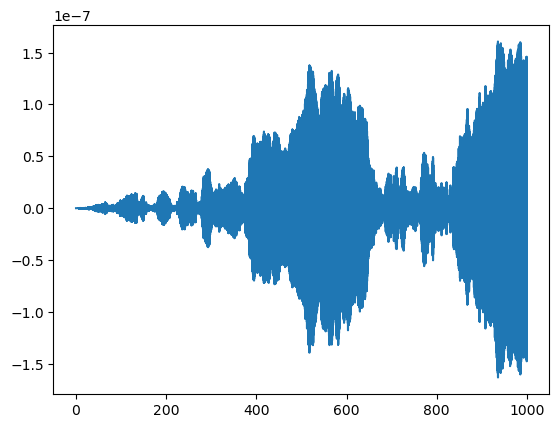

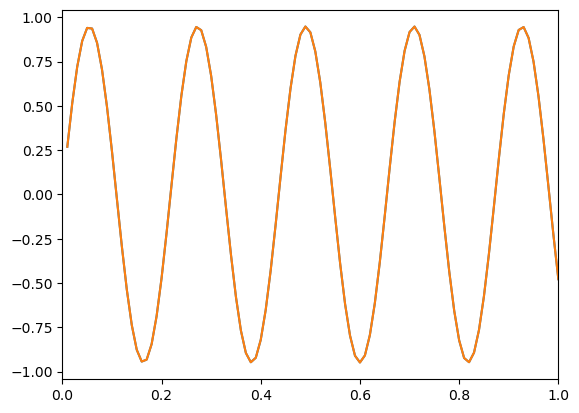

In [44]:
coord = 5
plt.plot(trueSolutionMidpoint[:-2, 0], trueSolutionMidpoint[:-2, coord] - trueSolution[:-2, coord])
plt.show()
plt.plot(trueSolutionMidpoint[:-2, 0], trueSolutionMidpoint[:-2, coord])
plt.plot(trueSolution[:-2, 0], trueSolution[:-2, coord])
plt.xlim(0, 1)
plt.show()

In [125]:
def sinFunc(x, freq):
	return np.sin(x*2*np.pi*freq)

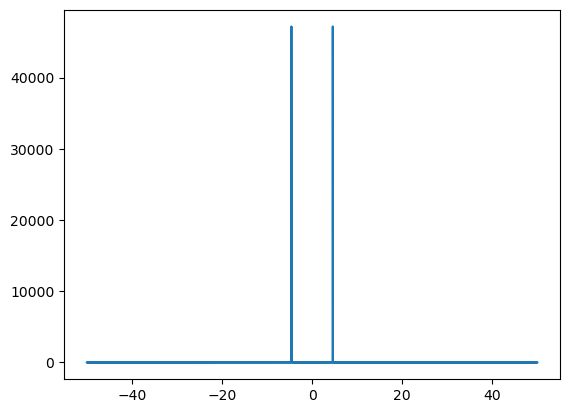

4.584045840458405


In [126]:
fftbins = np.fft.fftfreq(len(trueSolutionMidpoint[:-2, 0]), trueSolutionMidpoint[2, 0]-trueSolutionMidpoint[1, 0])
plt.plot(fftbins, np.abs(np.fft.fft(trueSolutionMidpoint[:-2, coord])))
plt.show()
print(fftbins[np.argmax(np.abs(np.fft.fft(trueSolutionMidpoint[:-2, coord])))])

(array([4.57985915]), array([[1.38989091e-12]]))


(998.0, 1000.0)

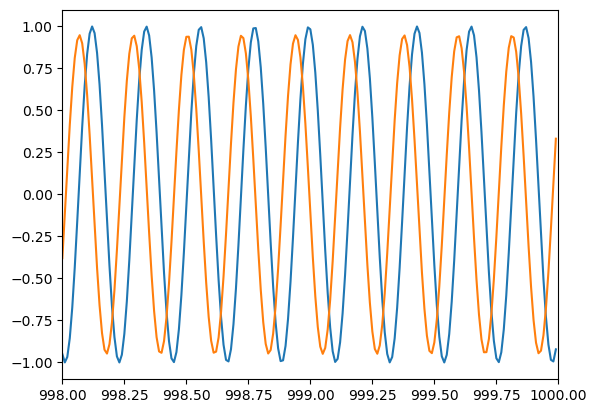

In [128]:
p0 = [4.58]
res = scipy.optimize.curve_fit(sinFunc, trueSolutionMidpoint[:-2, 0], trueSolutionMidpoint[:-2, coord], p0=p0)
print(res)
plt.plot(trueSolutionMidpoint[:-2, 0], sinFunc(trueSolutionMidpoint[:-2, 0], res[0][0]))
plt.plot(trueSolutionMidpoint[:-2, 0], trueSolutionMidpoint[:-2, coord])
plt.xlim(998, 1000)

In [139]:
init = 4.58
last = np.inf
movedir = 'right'
minStepSize = 1.0e-8
curStepSize = 1.0e-2
steps = []
while True:
	test = np.sin(init * trueSolutionMidpoint[:-2, 0] * np.pi * 2.0)
	diff = np.subtract(test, trueSolutionMidpoint[:-2, coord])
	thisRes = np.sum(np.square(diff))/len(diff)
	steps.append((init, thisRes))
	print(curStepSize, thisRes)
	if thisRes < last: #if this result is better than the last one, keep going this direction
		init = init + curStepSize
		last = thisRes
	else:
		curStepSize = curStepSize / 2.0
		if movedir == 'right':
			movedir = 'left'
			init = init - curStepSize
		elif movedir == 'left':
			movedir = 'right'
			init = init + curStepSize
	if curStepSize < minStepSize:
		break

0.01 0.9278668339047011
0.01 0.9654154885219541
0.005 1.0512630241290264
0.0025 0.923249053298191
0.0025 0.9654154885218352
0.00125 0.9759278036599339
0.000625 0.921653612275371
0.000625 0.965415488521721
0.0003125 0.9636949997550941
0.00015625 0.9762529703934965
7.8125e-05 0.9727462478411917
3.90625e-05 0.975269214634286
1.953125e-05 0.9741940494039324
9.765625e-06 0.9747791998188966
4.8828125e-06 0.9744984070561084
2.44140625e-06 0.9746417636218048
1.220703125e-06 0.9745708236184484
6.103515625e-07 0.9746064784142539
3.0517578125e-07 0.9745886971870433
1.52587890625e-07 0.9745975993468193
7.62939453125e-08 0.9745931511530391
3.814697265625e-08 0.9745953759715107
1.9073486328125e-08 0.9745942637426895


(4.5, 4.6)

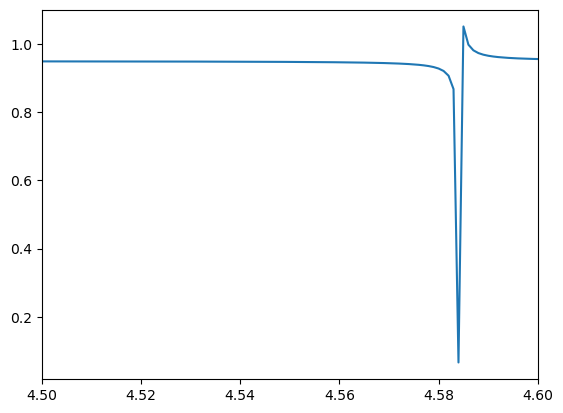

In [134]:
plt.plot(fs, residuals)
plt.xlim(4.5, 4.6)

In [ ]:
options = integratorOptions()
t0 = 0
tf = 1.0
numSteps = 10000
options['ioutInt'] = (tf - t0)/numSteps
outputArrayRK45 = np.zeros((numSteps+1, 7), dtype=precision)
outputArrayRK45Rot = np.zeros((numSteps+1, 7), dtype=precision)
outputArrayRK45Quat = np.zeros((numSteps+1, 7), dtype=precision)
outputArrayDOPNorm = np.zeros((numSteps+1, 7), dtype=precision)
outputArrayDOPRot = np.zeros((numSteps+1, 7), dtype=precision)
outputArrayDOPQuat = np.zeros((numSteps+1, 7), dtype=precision)
outputArrayRK7109 = np.zeros((numSteps+1, 7), dtype=precision)
outputArrayRK7109Rot = np.zeros((numSteps+1, 7), dtype=precision)

In [ ]:
options['rtol'] = 1.0e-14
options['atol'] = 1.0e-14
start = time.time()
rk7109Steps = RK75109(t0, tf, s[:], x, x, v, v, options, 0, 0, outputArrayRK7109)
stop = time.time()
print('RK7109:', rk7109Steps, stop-start, rk7109Steps/(stop-start), (tf-t0)/rk7109Steps)

In [ ]:
options['rtol'] = 1.0e-14
options['atol'] = 1.0e-14
start = time.time()
rk7109StepsRot = RK75109Rotation(t0, tf, s[:], x, x, v, v, options, 0, 0, outputArrayRK7109Rot)
stop = time.time()
print('RK7109:', rk7109StepsRot, stop-start, rk7109StepsRot/(stop-start), (tf-t0)/rk7109StepsRot)

In [ ]:
options['rtol'] = 1.0e-14
options['atol'] = 1.0e-14
start = time.time()
rk45Steps = RK45(t0, tf, s[:], x, x, v, v, options, 0, 0, outputArrayRK45)
stop = time.time()
print('RK45 Normal:', rk45Steps, stop-start, rk45Steps/(stop-start), (tf-t0)/rk45Steps)

In [ ]:
options['rtol'] = 1.0e-14
options['atol'] = 1.0e-14
start = time.time()
rk45StepsRot = RK45Rotations(t0, tf, s[:], x, x, v, v, options, 0, 0, outputArrayRK45Rot)
stop = time.time()
print('RK45 Rotations:', rk45StepsRot, stop-start, rk45StepsRot/(stop-start), (tf-t0)/rk45StepsRot)

In [ ]:
options['rtol'] = 1.0e-14
options['atol'] = 1.0e-14
start = time.time()
rk45StepsQuat = RK45Quaternions(t0, tf, s[:], x, x, v, v, options, 0, 0, outputArrayRK45Quat)
stop = time.time()
print('RK45 Quaternions:', rk45StepsQuat, stop-start, rk45StepsQuat/(stop-start), (tf-t0)/rk45StepsQuat)

In [ ]:
options['rtol'] = 1.0e-14
options['atol'] = 1.0e-14
start = time.time()
dopSteps = DOP853(t0, tf, s[:], x, x, v, v, options, 0, 0, outputArrayDOPNorm)
stop = time.time()
print('DOP853Normal:', dopSteps, stop-start, dopSteps/(stop-start), (tf-t0)/dopSteps)

In [ ]:
options['rtol'] = 1.0e-14
options['atol'] = 1.0e-14
start = time.time()
dopRotSteps = DOP853Rotation(t0, tf, s[:], x, x, v, v, options, 0, 0, outputArrayDOPRot)
stop = time.time()
print('DOP853Rot:', dopRotSteps, stop-start, dopRotSteps/(stop-start), (tf-t0)/dopRotSteps)

In [ ]:
options['rtol'] = 1.0e-14
options['atol'] = 1.0e-14
start = time.time()
dopQuatSteps = DOP853Quaternion(t0, tf, s[:], x, x, v, v, options, 0, 0, outputArrayDOPQuat)
stop = time.time()
print('DOP853Rot:', dopQuatSteps, stop-start, dopQuatSteps/(stop-start), (tf-t0)/dopQuatSteps)

In [ ]:
coord = 6
plt.scatter(trueSolution[:-2, 0], np.abs(trueSolution[:-2, coord] - outputArrayRK45[:-2, coord]), s=0.5)
plt.scatter(trueSolution[:-2, 0], np.abs(trueSolution[:-2, coord] - outputArrayRK7109[:-2, coord]), s=0.5)
plt.scatter(trueSolution[:-2, 0], np.abs(trueSolution[:-2, coord] - outputArrayRK45Quat[:-2, coord]), s=0.5)
plt.scatter(trueSolution[:-2, 0], np.abs(trueSolution[:-2, coord] - outputArrayRK45Rot[:-2, coord]), s=0.5)
plt.show()

In [ ]:
tolerances = np.logspace(-5, -14, 10)

methods = [RK45, RK45Rotations, RK45Quaternions, DOP853, DOP853Rotation, DOP853Quaternion]
methodNames = ['RK45', 'RK45 Rotation', 'RK45 Quaternion', 'DOP853', 'DOP853 Rotation', 'DOP853 Quaternion']

results = []
times = []
steps = []
tols = []
options = integratorOptions()
t0 = 0
tf = 2.0
numSteps = 500
options['ioutInt'] = (tf - t0)/numSteps
for tol in tolerances:
	print('Starting tol = ', tol)
	for method in methods:
		output = np.zeros((numSteps+1, 7), dtype=precision)
		options['rtol'] = tol
		options['atol'] = tol
		start = time.time()
		step = method(t0, tf, s[:], x, x, v, v, options, 0, 0, output)
		stop = time.time()
		results.append(output)
		times.append(stop-start)
		steps.append(step)
		tols.append(tol)

results = np.array(results)
times = np.array(times)
steps = np.array(steps)
tols = np.array(tols)

In [ ]:
tol1 = 9
coord = 4

print(methodNames[3], tolerances[tol1], coord)
reference = results[len(methods)*tol1+3][1:-1,coord]

for meth in range(len(methodNames)):
	for tol2 in range(0, len(tolerances)-1):
		plt.plot(results[len(methods)*tol1+meth][:-2,0], np.abs(results[len(methods)*tol2+meth][:-2,coord] - reference), label=tolerances[tol2])
	plt.yscale('log')
	plt.legend()
	plt.title("Tolerance Differences for "+methodNames[meth])
	plt.show()

In [ ]:
plt.plot(tols.reshape(-1, len(methods)), times.reshape(-1, len(methods)), label=methodNames)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Tolerance')
plt.ylabel('Time Taken')
plt.show()

plt.plot(tols.reshape(-1, len(methods)), steps.reshape(-1, len(methods)), label=methodNames)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Tolerance')
plt.ylabel('Number of Steps')
plt.show()

In [ ]:
times.reshape(-1, len(methods))
tols.reshape(-1, len(methods))

In [ ]:
plt.scatter(tols, DOPNormSteps, label='Normal DOP853')
plt.scatter(tols, RK45RotSteps, label='RK45 Rotations')
plt.scatter(tols, RK45QuatSteps, label='RK45 Quaternions')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Solver Tolerance')
plt.ylabel('Number of Steps Taken')
plt.legend()
plt.show()

plt.scatter(tols, DOPNormTimes, label='Normal DOP853')
plt.scatter(tols, RK45RotTimes, label='RK45 Rotations')
plt.scatter(tols, RK45QuatTimes, label='RK45 Quaternions')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Solver Tolerance')
plt.ylabel('Time Taken (s)')
plt.legend()
plt.show()

In [ ]:
# first compare results with each other, just at different tolerances
coord = 6
for i in range(0, len(tols)):
	label = str(tols[i]) + ': '+str(np.sum(np.abs(DOPNormRes[-1][1:-1,coord]-DOPNormRes[i][1:-1,coord])))
	plt.scatter(DOPNormRes[i][1:-1, 0], abs(DOPNormRes[-1][1:-1,coord]-DOPNormRes[i][1:-1,coord]), label=label, s=1)
plt.legend()
plt.yscale('log')
plt.show()

# first compare results with each other, just at different tolerances
for i in range(0, len(tols)):
	label = str(tols[i]) + ': '+str(np.sum(np.abs(RK45RotRes[-1][1:-1,coord]-RK45RotRes[i][1:-1,coord])))
	plt.scatter(RK45RotRes[i][1:-1, 0], abs(RK45RotRes[-1][1:-1,coord]-RK45RotRes[i][1:-1,coord]), label=label, s=1)
plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
for i in range(len(tols)):
	coord = 6
	plt.scatter(outputArrayDOPNorm[1:-1, 0], outputArrayDOPNorm[1:-1,coord], s=1)
	plt.scatter(outputArrayRK45[:-2,0], outputArrayRK45[:-2,coord], s=1)
	plt.scatter(outputArrayDOPRot[:-2,0], outputArrayDOPRot[:-2,coord], s=1)
	plt.show()

	plt.scatter(outputArrayDOPNorm[1:-1, 0], outputArrayDOPNorm[1:-1,coord]-outputArrayRK45[:-2,coord], s=1)
	#plt.scatter(outputArrayDOPNorm[1:-1, 0], outputArrayDOPNorm[1:-1,coord]-outputArrayDOPRot[:-2,coord], s=1)
	plt.show()

In [ ]:
options['rtol'] = 1.0e-14
options['atol'] = 1.0e-14
start = time.time()
dopSteps = DOP853(t0, tf, s[:], x, x, v, v, options, 0, 0, outputArrayDOPNorm)
stop = time.time()
print('DOP:', dopSteps, stop-start, dopSteps/(stop-start), (tf-t0)/dopSteps)

In [ ]:
options['rtol'] = 1.0e-14
options['atol'] = 1.0e-14
start = time.time()
rk45Steps = RK45Method(t0, tf, s[:], x, x, v, v, options, 0, 0, outputArrayRK45)
stop = time.time()
print('RK45:', rk45Steps, stop-start, rk45Steps/(stop-start), (tf-t0)/rk45Steps)

In [ ]:
options['rtol'] = 1.0e-14
options['atol'] = 1.0e-14
start = time.time()
dopStepsRot = DOP853Rotation(t0, tf, s[:], x, x, v, v, options, 0, 0, outputArrayDOPRot)
stop = time.time()
print('DOP:', dopStepsRot, stop-start, dopStepsRot/(stop-start), (tf-t0)/dopStepsRot)

In [ ]:
coord = 6
plt.scatter(outputArrayDOPNorm[1:-1, 0], outputArrayDOPNorm[1:-1,coord], s=1)
plt.scatter(outputArrayRK45[:-2,0], outputArrayRK45[:-2,coord], s=1)
plt.scatter(outputArrayDOPRot[:-2,0], outputArrayDOPRot[:-2,coord], s=1)
plt.show()

plt.scatter(outputArrayDOPNorm[1:-1, 0], outputArrayDOPNorm[1:-1,coord]-outputArrayRK45[:-2,coord], s=1)
#plt.scatter(outputArrayDOPNorm[1:-1, 0], outputArrayDOPNorm[1:-1,coord]-outputArrayDOPRot[:-2,coord], s=1)
plt.show()

In [ ]:
coord = 6
plt.scatter(outputArrayDOPNorm[1:-1, 0], outputArrayDOPNorm[1:-1,coord], s=1)
plt.scatter(outputArrayRK45[:-2,0], outputArrayRK45[:-2,coord], s=1)
plt.scatter(outputArrayDOPRot[:-2,0], outputArrayDOPRot[:-2,coord], s=1)
plt.show()

plt.scatter(outputArrayDOPNorm[1:-1, 0], outputArrayDOPNorm[1:-1,coord]-outputArrayRK45[:-2,coord], s=1)
#plt.scatter(outputArrayDOPNorm[1:-1, 0], outputArrayDOPNorm[1:-1,coord]-outputArrayDOPRot[:-2,coord], s=1)
plt.show()